# **Analisis de Nomina Estatales Rep. Dominicana**

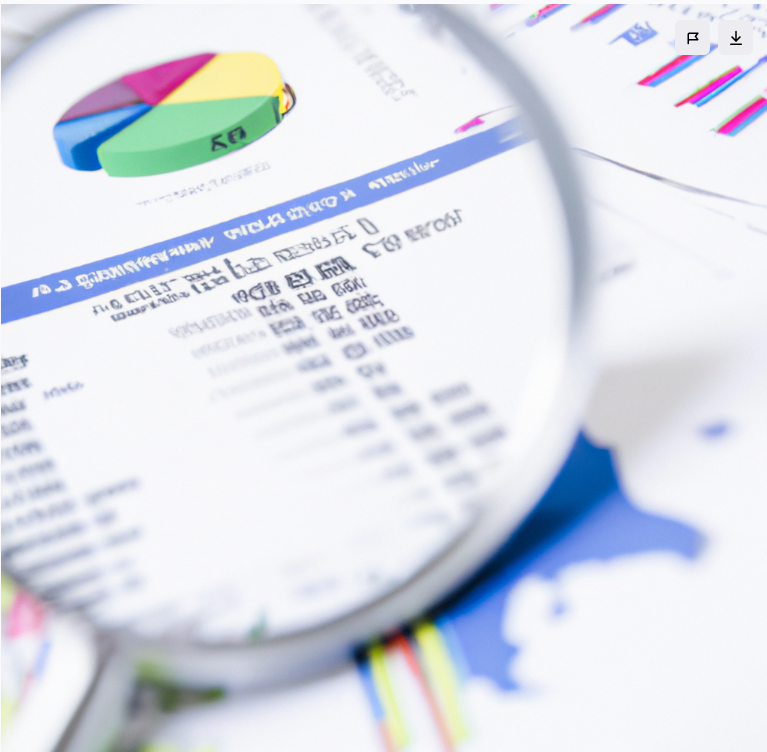

### "Análisis de Nómina de Empleados Estatales en la República Dominicana" podría estar diseñado para automatizar la tarea de procesar y analizar grandes cantidades de datos relacionados con la nómina de empleados del gobierno en la República Dominicana. Este script incluye los siguientes elementos:

* Recopilación de datos: el script podría acceder a una base de datos que contenga información sobre los empleados estatales y sus salarios, beneficios y deducciones.

* Procesamiento de datos: el script podría realizar cálculos y transformaciones en los datos, por ejemplo, para calcular el salario neto de los empleados después de las deducciones de impuestos y otros descuentos.

* Análisis de datos: el script podría utilizar técnicas de análisis de datos para identificar patrones y tendencias en la nómina, como los salarios promedio por puesto de trabajo, el número de empleados que reciben ciertos tipos de beneficios y deducciones, y las desviaciones en los pagos.

* Generación de informes: el script podría generar informes personalizados que muestren los resultados del análisis de datos en formatos útiles, como gráficos y tablas, para facilitar la comprensión de los datos por parte de los usuarios.

# Librerias

In [5]:
!pip install pyodbc
!pip install nltk
!pip install sweetviz

import os
from pathlib import Path
import csv
import random

import pandas as pd
import openpyxl
import numpy as np
#import webbrowser
import matplotlib.pyplot as plt

from datetime import datetime as dt
from pandas import Series
import re
import datetime
import time

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet as wn
from nltk import FreqDist
import string

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import seaborn as sns

import math 
import sweetviz as sv
#####Para ignorar las advertencias
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Dataset

### Carga de los datasets a usar

In [6]:
%%time

df_1 = pd.read_excel("/kaggle/input/estimacion-ingreso-publicas-07/ESTIMACION_INGRESO_PUBLICAS_07.xlsx")
df_2 = pd.read_excel("/kaggle/input/tbl-estimacion-ingreso-publicas-08/tbl_ESTIMACION_INGRESO_PUBLICAS_08.xlsx")
df_3 = pd.read_excel("/kaggle/input/tbl-estimacion-ingreso-publicas--09/tbl_ESTIMACION_INGRESO_PUBLICAS_09.xlsx")

profesiones = pd.read_excel("/kaggle/input/profesiones-estatal/fuzzy_funcion.xlsx")
def_fun = pd.read_excel("/kaggle/input/def-fun/def_func.xlsx")

prov_rd = pd.read_excel('/kaggle/input/dominican-republic-provincias-coord/tbl_GEO_Provincias.xlsx')
prov_rd['Cod_Provincia'] = prov_rd['Cod_Provincia'].astype('str',errors ="ignore")
prov_rd['Cod_Provincia'].replace('1', '01', inplace=True)
prov_rd['Cod_Provincia'].replace('2', '02', inplace=True)
prov_rd['Cod_Provincia'].replace('3', '03', inplace=True)
prov_rd['Cod_Provincia'].replace('4', '04', inplace=True)
prov_rd['Cod_Provincia'].replace('5', '05', inplace=True)
prov_rd['Cod_Provincia'].replace('6', '06', inplace=True)
prov_rd['Cod_Provincia'].replace('7', '07', inplace=True)
prov_rd['Cod_Provincia'].replace('8', '08', inplace=True)
prov_rd['Cod_Provincia'].replace('9', '09', inplace=True)
prov_rd['Cod_Provincia'].replace('10', '10', inplace=True)

CPU times: user 5min 47s, sys: 944 ms, total: 5min 48s
Wall time: 5min 50s


# Consolidado de Nominas

In [7]:
%%time

fecha_hoy = datetime.datetime.now()

##,Procedemos,a,concatenar,todos,los,datasets,de,nomina,ya,realizados

   
df=pd.concat([
    
df_1,
df_2,
df_3
    
       ],ignore_index=True)
    
#Limpieza del dataset
df.columns = df.columns.str.strip() #eliminar espacios blancos extras



df = df.drop_duplicates(subset=['NOMBRE_COMPLETO'])
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df['FECHA_ACTUALIZACION'] = pd.to_datetime(df['FECHA_ACTUALIZACION'])   

CPU times: user 2.83 s, sys: 412 ms, total: 3.25 s
Wall time: 3.26 s


In [8]:
def_fun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8087 entries, 0 to 8086
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   FUNCION          8087 non-null   object
 1   fun_normalizada  8087 non-null   object
dtypes: object(2)
memory usage: 126.5+ KB


# ETL

### Se inicia el proceso de Extraccion, Transformacion y Carga, para depurar las variables a a utilizar y normalizar los campos de las columnas. Bajo este bloque:
* Se Clusterizan las Intituciones por tipo, para mejor manejo de los filtros.
* Se Normaliza los Tipos de Empleos, ejemplo: Fijo, Contrato, Pensionado a tipos uniformes.
* Se Agregan variables random para hacer featuring engienier (Edad, Rango Edad y Provincias).
* Se crea una funcion para agrupar las edades por rangos.
* Join a la tabla de Provincias para traer el nombre de las provincias de los Empleados.
* Join con la tabla func_def, la misma es un algoritmo desarrollado donde se extrae la raiz de de la funcion del empleado.

El código agrupa a las instituciones en grupos según sus nombres. Los clústeres están definidos por las asignaciones en las sentencias df.loc. Por ejemplo, el código está asignando el valor "ADMINISTRATIVO" a la columna "CLUSTER_INSTITUCION" para las filas donde la columna "INSTITUCIÓN" tiene el valor "CONSEJO NACIONAL DE PROMOCIÓN Y APOYO A LA MICRO PEQUEÑA Y MEDIANA EMPRESA (PROMIPYME)".

Parece que los clústeres se asignan en función de alguna heurística, ya que el código no parece estar utilizando ningún dato externo para definir los clústeres.

In [9]:
%%time

#////////////////////////////////////////CLASIFICACION DE INSTITUCION ////////////////////////////////////////////////

df.loc[df['INSTITUCION'] == 'ADMINISTRADORA DE RIESGOS DE SALUD PARA MAESTROS', 
                                                    'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'ARMADA DE LA REPUBLICA DOMINICANA', 'CLUSTER_INSTITUCION'] = 'CASTRENSE'
df.loc[df['INSTITUCION'] == 'AUTORIDAD PORTUARIA DOMINICANA', 'CLUSTER_INSTITUCION'] = 'CASTRENSE'
df.loc[df['INSTITUCION'] == 'CDEE', 'CLUSTER_INSTITUCION'] = 'ENERGIA'
df.loc[df['INSTITUCION'] == 'CENTRO DE OPERACIONES DE EMERGENCIAS (COE)'
                                                   , 'CLUSTER_INSTITUCION'] = 'MEDIO AMBIENTE'
df.loc[df['INSTITUCION'] == 'CONSEJO NACIONAL DE DISCAPACIDAD', 'CLUSTER_INSTITUCION'] = 'SALUD'
df.loc[df['INSTITUCION'] == 'CONSEJO NACIONAL DE DROGAS', 'CLUSTER_INSTITUCION'] = 'SALUD'
df.loc[df['INSTITUCION'] == 'CONSEJO NACIONAL DE PROMOCION Y APOYO A LA MICRO PEQUEÑA Y MEDIANA EMPRESA (PROMIPYME)',
                                                    'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'CONANI','CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'CORPORACION DE ACUEDUCTO Y ALCANTARILLADO DE SANTO DOMINGO (CAASD)', 
                                                    'CLUSTER_INSTITUCION'] = 'MEDIO AMBIENTE'
df.loc[df['INSTITUCION'] == 'CUERPO ESPECIALIZADO EN SEGURIDAD AEROPORTUARIA Y DE LA AVIACION CIVIL (CESAC)', 
                                                    'CLUSTER_INSTITUCION'] = 'CASTRENSE'
df.loc[df['INSTITUCION'] == 'CUERPO ESPECIALIZADO PARA LA SEGURIDAD DEL METRO (CESMET)', 
                                                    'CLUSTER_INSTITUCION'] = 'CASTRENSE'
df.loc[df['INSTITUCION'] == 'DEFENSA CIVIL','CLUSTER_INSTITUCION'] = 'CASTRENSE'
df.loc[df['INSTITUCION'] == 'DIRECCION GENERAL DE BIENES NACIONALES'
                                                   , 'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'DIRECCION GENERAL DE CONTRATACIONES PUBLICAS', 
                                                    'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'DIRECCION GENERAL DE EMBELLECIMIENTO DE CARRETERAS Y AVENIDAS DE CIRCUNVALACION (DIGECAC)', 
                                                    'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'DIRECCION GENERAL DE ETICA E INTEGRIDAD GUBERNAMENTAL (DIGEIG)', 
                                                    'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'DIRECCION GENERAL DE IMPUESTOS INTERNOS (DGII)', 
                                                    'CLUSTER_INSTITUCION'] = 'FINANZAS'
df.loc[df['INSTITUCION'] == 'EDEESTE','CLUSTER_INSTITUCION'] = 'ENERGIA'
df.loc[df['INSTITUCION'] == 'EDENORTE','CLUSTER_INSTITUCION'] = 'ENERGIA'
df.loc[df['INSTITUCION'] == 'EDESUR','CLUSTER_INSTITUCION'] = 'ENERGIA'
df.loc[df['INSTITUCION'] == 'EJERCITO DE LA REPUBLICA DOMINICANA'
                                                   ,'CLUSTER_INSTITUCION'] = 'CASTRENSE'
df.loc[df['INSTITUCION'] == 'INSTITUTO AGRARIO DOMINICANO (IAD)'
                                                   ,'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'INSTITUTO DE DESARROLLO Y CREDITO COOPERATIVO (IDECOOP)',
                                                   'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'INSTITUTO DE ESTABILIZACIÓN DE PRECIOS (INESPRE)',
                                                   'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'INSTITUTO DOMINICANO DE AVIACION CIVIL (IDAC)',
                                                   'CLUSTER_INSTITUCION'] = 'CASTRENSE'
df.loc[df['INSTITUCION'] == 'INSTITUTO DOMINICANO DE TELECOMUNICACIONES (INDOTEL)',
                                                   'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'INSTITUTO NACIONAL DE AGUAS POTABLES Y ALCANTARILLADOS (INAPA)'
                                                   ,'CLUSTER_INSTITUCION'] = 'MEDIO AMBIENTE'
df.loc[df['INSTITUCION'] == 'INSTITUTO NACIONAL DE ATENCION INTEGRAL A LA PRIMERA INFANCIA (INAIPI)'
                                                   ,'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'INSTITUTO NACIONAL DE BIENESTAR ESTUDIANTIL (INABIE)'
                                                   ,'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'INSTITUTO NACIONAL DE FORMACION TECNICO PROFESIONAL (INFOTEP)',
                                                       'CLUSTER_INSTITUCION'] = 'EDUCACION'
df.loc[df['INSTITUCION'] == 'INSTITUTO NACIONAL DE PROTECCION DE LOS DERECHOS DEL CONSUMIDOR (PROCONSUMIDOR)'
                                                   ,'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'INSTITUTO NACIONAL DE TRANSITO Y TRANSPORTE TERRESTRE (INTRANT)'
                                                   ,'CLUSTER_INSTITUCION'] = 'TRANSPORTE'
df.loc[df['INSTITUCION'] == 'INSTITUTO TECNOLOGICO DE LAS AMERICAS (ITLA)',
                                                       'CLUSTER_INSTITUCION'] = 'EDUCACION'
df.loc[df['INSTITUCION'] == 'MINISTERIO ADMINISTRATIVO DE LA PRESIDENCIA (MAPRE)',
                                                   'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE ADMINISTRACION PUBLICA (MAP)',
                                                   'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE AGRICULTURA','CLUSTER_INSTITUCION'] = 'MEDIO AMBIENTE'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE CULTURA','CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE DEFENSA (MIDE)','CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE DEPORTES','CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE ECONOMIA','CLUSTER_INSTITUCION'] = 'FINANZAS'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE EDUCACION','CLUSTER_INSTITUCION'] = 'EDUCACION'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE EDUCACION SUPERIOR CIENCIA Y TECNOLOGIA (MESCYT)'
                                                   ,'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE HACIENDA','CLUSTER_INSTITUCION'] = 'FINANZAS'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE INDUSTRIA Y COMERCIO'
                                                   ,'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE INTERIOR Y POLICIA','CLUSTER_INSTITUCION'] = 'CASTRENSE'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE JUVENTUD','CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE LA MUJER','CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE LA VIVIENDA HABITAD Y EDIFICACIONES (MIVHED)',
                                                   'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE MINAS','CLUSTER_INSTITUCION'] = 'ENERGIA'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE SALUD','CLUSTER_INSTITUCION'] = 'SALUD'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE TRABAJO','CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE TURISMO','CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'OFICINA NACIONAL DE ESTADISTICA (ONE)'
                                                       ,'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'OFICINA NACIONAL DE LA PROPIEDAD INDUSTRIAL (ONAPI)'
                                                    ,'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'OFICINA NACIONAL DE METEOROLOGIA (ONAMET)'
                                                   ,'CLUSTER_INSTITUCION'] = 'MEDIO AMBIENTE'
df.loc[df['INSTITUCION'] == 'OFICINA PARA EL REORDENAMIENTO DEL TRANSPORTE (OPRET)',
                                                    'CLUSTER_INSTITUCION'] = 'TRANSPORTE'
df.loc[df['INSTITUCION'] == 'OMSA','CLUSTER_INSTITUCION'] = 'TRANSPORTE'
df.loc[df['INSTITUCION'] == 'PROCURADURIA GENERAL DE LA REPUBLICA'
                                                   ,'CLUSTER_INSTITUCION'] = 'CASTRENSE'
df.loc[df['INSTITUCION'] == 'PROINDUSTRIA','CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'PROMESECAL','CLUSTER_INSTITUCION'] = 'SALUD'
df.loc[df['INSTITUCION'] == 'SERVICIO NACIONAL DE SALUD (SENASA)','CLUSTER_INSTITUCION'] = 'SALUD'
df.loc[df['INSTITUCION'] == 'SERVICIO NACIONAL DE SALUD (SNS)','CLUSTER_INSTITUCION'] = 'SALUD'
df.loc[df['INSTITUCION'] == 'SUPERINTENDECIA DE BANCOS','CLUSTER_INSTITUCION'] = 'FINANZAS'
df.loc[df['INSTITUCION'] == 'SUPERINTENDECIA DE ELECTRICIDAD','CLUSTER_INSTITUCION'] = 'ENERGIA'
df.loc[df['INSTITUCION'] == 'SUPERINTENDECIA DE PENSIONES (SIPEN)','CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'SUPERINTENDENCIA DE SALUD Y RIESGOS LABORALES (SISALRIL)'
                                                   ,'CLUSTER_INSTITUCION'] = 'SALUD'
df.loc[df['INSTITUCION'] == 'SUPERINTENDENCIA DE SEGUROS','CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'TESORERIA NACIONAL','CLUSTER_INSTITUCION'] = 'FINANZAS'
df.loc[df['INSTITUCION'] == 'UNIVERSIDAD AUTONOMA DE SANTO DOMINGO (UASD)'
                                                   ,'CLUSTER_INSTITUCION'] = 'EDUCACION'
df.loc[df['INSTITUCION'] == 'ZOOLOGICO NACIONAL','CLUSTER_INSTITUCION'] = 'MEDIO AMBIENTE'
df.loc[df['INSTITUCION'] == 'CONTRALORIA','CLUSTER_INSTITUCION'] = 'FINANZAS'
df.loc[df['INSTITUCION'] == 'DIRECCION NACIONAL DE MIGRACION','CLUSTER_INSTITUCION'] = 'CASTRENSE'
df.loc[df['INSTITUCION'] == 'DIRECCION NACIONAL DE PRESUSPUESTO','CLUSTER_INSTITUCION'] = 'FINANZAS'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE MEDIO AMBIENTE','CLUSTER_INSTITUCION'] = 'MEDIO AMBIENTE'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE RELACIONES EXTERIORES'
                                       ,'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE EDUCACION SUPERIOR CIENCIA Y TECNOLOGIA (MESCYT)'
                                       ,'CLUSTER_INSTITUCION'] = 'EDUCACION'
df.loc[df['INSTITUCION'] == 'CONSEJO NACIONAL DE PROMOCION Y APOYO A LA MICRO PEQUEÑA Y MEDIANA EMPRESA (PROMIPYME)'
                                        ,'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'CONSJEO NACIONAL PARA EL VIH Y EL SIDA (CONAVIHSIDA)'
                                       ,'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'CONSEJO NACIONAL PARA LA NIÑEZ Y LA ADOLESCENCIA (CONANI)'
                                   ,'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'

#//////////////////////////////////////////////////////////////////////////////////////////

## Carrera Adm.
df['TIPO_EMPLEADO'] = df['TIPO_EMPLEADO'].replace(
    to_replace=['DE CARRERA', 'EMPLEADA DE CARRERA ADMINISTRATIVA', 'EMPLEADA DE CARRERA ADMINISTRATIVA','EMPLEADO DE CARRERA ADMINISTRATIVA','CARRERA ADM.',
                '2. CARRERA','CARRERA','CARRERA DAM.','EMPLEADO DE CARRERA'], 
    value='CARRERA ADMINISTRATIVA')

## Cargo de Confianza.
df['TIPO_EMPLEADO'] = df['TIPO_EMPLEADO'].replace(
    to_replace=['EMP DE CONFIANZA','DE CONFIANZA','CARGOS DE CONFIANZA','CONFIANZA','D/CONFIANZA','EMPLEADO DE CONFIANZA','PERSONAL DE CONFIANZA'], 
    value='CARGO DE CONFIANZA')

## Designado
df['TIPO_EMPLEADO'] = df['TIPO_EMPLEADO'].replace(
    to_replace=['DESIGNADO/CARRERA ADMINISTRATIVA','DESIGNADO DEC NUM 176-21','DESIGNADAS','DESIGNADA','DESIGANDO'], 
    value='DESIGNADO')

## Estatuto Simplificado
df['TIPO_EMPLEADO'] = df['TIPO_EMPLEADO'].replace(
    to_replace=['SIMPLIFICADOS','ESTATUTO SIMP','ESTATUTO SIMPLIFICADO','ESTATUTO SIMP',
                'ESTATUTOS SIMPLIFICADOS','STATUTO SIMPLIFICADO', 'STATUTO SIMPLIFICADO]','3. ESTATUTO SIMPLIFICADO','STATUTO SIMPLIFIADO'], 
    value='ESTATUS SIMPLIFICADO')

## Fijo
df['TIPO_EMPLEADO'] = df['TIPO_EMPLEADO'].replace(
    to_replace=['FIJOS','FIJOII','FIJO II','EMP FIJO','*FIJO','EMPLEADA FIJA (POR DECRETO)', 'EMPLEADA FIJA','EMPLEADO FIJO (POR DECRETO)','EMPLEADO FIJO','PERSONAL FIJO'], 
    value='FIJO')

## Libre Nombramiento
df['TIPO_EMPLEADO'] = df['TIPO_EMPLEADO'].replace(
    to_replace=['LIBRE NOMBRAMIENTO Y REMOCIÓN','LIBRE NOM Y REMOCIÓN','1. LIBRE NOMBRAMIENTO Y REM.','DE LIBRE NOMBRAMIENTO Y REMOCION','LIBRE  NOMBRAMIENTO Y REMOCIÓN','DE LIBRE NOMBRAMIENTO Y REMOCIÓN',
               'LIBRE  NOMBRAMIENTO Y REMOCIÓN','LIBRE NOMBRAMIENTO \nY REMOCION','LIBRE NOMBRAMIENTO','LIBRE NOMBRAMIENTO Y REMOCION'], 
    value='LIBRE NOMBRAMIENTO Y REMOCION')

## Probatorio
df['TIPO_EMPLEADO'] = df['TIPO_EMPLEADO'].replace(
    to_replace=['PERIODO PROBATORIO INGRESO CAR','P.PRUEBA','PERIODO PROBATORIO INGRESO CARRERA','4. TEMPORALES','TEMPORAL','EMPLEADOS TEMPORALES'], 
    value='PROBATORIO')

## Pensionados
df['TIPO_EMPLEADO'] = df['TIPO_EMPLEADO'].replace(
    to_replace=['PRE PENSION','TRAMITE DE PENSION','TRAMITE DE PENSIÓN','TRÁMITE DE PENSIÓN'], 
    value='PENSIONADO')


# ///////////////////////////////////////////////////////////////////////////////////////
df.loc[df['TIPO_EMPLEADO'] == 'FIJO', 'TIPO_EMPLEADO'] = 'FIJO'
df.loc[df['TIPO_EMPLEADO'] == 'CARRERA ADMINISTRATIVA', 'TIPO_EMPLEADO'] = 'CARRERA ADMINISTRATIVA'
df.loc[df['TIPO_EMPLEADO'] == 'CONTRATADO', 'TIPO_EMPLEADO'] = 'CONTRATADO'
df.loc[df['TIPO_EMPLEADO'] == 'ESTATUTO SIMPLIFICADO', 'TIPO_EMPLEADO'] = 'ESTATUTO SIMPLIFICADO'
df.loc[df['TIPO_EMPLEADO'] == 'DESIGNADO', 'TIPO_EMPLEADO'] = 'DESIGNADO'
df.loc[df['TIPO_EMPLEADO'] == 'CARGO DE CONFIANZA', 'TIPO_EMPLEADO'] = 'CARGO DE CONFIANZA'
df.loc[df['TIPO_EMPLEADO'] == 'LIBRE NOMBRAMIENTO Y REMOCION', 'TIPO_EMPLEADO'] = 'LIBRE NOMBRAMIENTO Y REMOCION'
df.loc[df['TIPO_EMPLEADO'] == 'PROBATORIO', 'TIPO_EMPLEADO'] = 'PROBATORIO'
df.loc[df['TIPO_EMPLEADO'] == 'PENSIONADO', 'TIPO_EMPLEADO'] = 'PENSIONADO'

df.loc[(df['TIPO_EMPLEADO'] != 'FIJO') 
                   & (df['TIPO_EMPLEADO'] != 'CARRERA ADMINISTRATIVA')
                   & (df['TIPO_EMPLEADO'] != 'CONTRATADO')
                   & (df['TIPO_EMPLEADO'] != 'ESTATUTO SIMPLIFICADO')
                   & (df['TIPO_EMPLEADO'] != 'DESIGNADO')
                   & (df['TIPO_EMPLEADO'] != 'CARGO DE CONFIANZA')
                   & (df['TIPO_EMPLEADO'] != 'LIBRE NOMBRAMIENTO Y REMOCION')
                   & (df['TIPO_EMPLEADO'] != 'PROBATORIO')
                   & (df['TIPO_EMPLEADO'] != 'PENSIONADO')
                   , 'TIPO_EMPLEADO'] = 'OTROS'


#///////////////////////////////////////////////////////////////////////////////////////////////////////

df['COD_PROVINCIA'] = np.random.randint(1,32,size=(len(df),1))
df['COD_PROVINCIA'] = df['COD_PROVINCIA'].round()
df['COD_PROVINCIA'] = df['COD_PROVINCIA'].astype('str',errors ="ignore")
df['COD_PROVINCIA'] = df['COD_PROVINCIA'].str.zfill(2)

df = pd.merge(df,prov_rd[['Provincia','Cod_Provincia']],how='left',left_on='COD_PROVINCIA',
                        right_on='Cod_Provincia')


#/////////////////////////////////////////////////////////////////////////

df['EDAD'] = np.random.randint(18,70,size=(len(df),1))
df['EDAD'] = df['EDAD'].round()
df['EDAD'] = df['EDAD'].astype('int',errors ="ignore")

#/////////////////////////////////////////////////////////////////////////////

def rango_edad(df):

     if (df['EDAD']<=18):
        return  "Rango Edad de 0 a 18 Años"
     if (df['EDAD']<25):
        return  "Rango Edad de 19-25"
     if (df['EDAD']<35):
        return  "Rango Edad de 26-35"
     if (df['EDAD']<45):
        return  "Rango Edad de 36-45"
     if (df['EDAD']<55):
        return  "Rango Edad de 46-55"
     if (df['EDAD']<65):
        return  "Rango Edad de 56-65"
     if (df['EDAD']<75):
        return  "Rango Edad de 66-75"
     if (df['EDAD']<85):
        return  "Rango Edad de 76-85"
     if (df['EDAD']<95):
        return  "Rango Edad de 86-95"
     else:
        return 'Otro'

df['Rango_Edad'] = df.apply(rango_edad, axis = 1)


CPU times: user 18 s, sys: 76.9 ms, total: 18 s
Wall time: 18.1 s


# Creacion Funcion de Profesion

In [10]:
df['FUNCION'] = df['FUNCION'].str.replace('}','')


df['FUNCION'] = df['FUNCION'].astype(str)
profesiones['Profesion'] = profesiones['Profesion'].astype(str)

df.columns = df.columns.str.strip() #eliminar espacios blancos extras
df['FUNCION'] = df['FUNCION'].str.lower()



# Definir función para encontrar la profesión en una fila
profesiones = list(profesiones["Profesion"].unique())
def encontrar_profesion(fila):
    for profesion in profesiones:
        if profesion in fila:
            return profesion
    return "Desconocido"

# Aplicar la función a cada fila y guardar el resultado en una nueva columna

df['Profesion'] = df['FUNCION'].apply(encontrar_profesion)
df

,NOMBRE_COMPLETO,AREA,FUNCION,GENERO,INSTITUCION,TIPO_EMPLEADO,SUELDO_BRUTO,SUELDO_NETO,FECHA_ACTUALIZACION,CLUSTER_INSTITUCION,COD_PROVINCIA,Provincia,Cod_Provincia,EDAD,Rango_Edad,Profesion
0,SONIA MIDALMA FELIZ MEDRANO,NaN,directora ejecutiva,FEMENINO,ADMINISTRADORA DE RIESGOS DE SALUD PARA MAESTROS,LIBRE NOMBRAMIENTO Y REMOCION,282000.00,194611.60,2022-07-22,ADMINISTRATIVO,02,AZUA,02,34,Rango Edad de 26-35,director
1,BRINA GUZMAN CARRERAS,NaN,coordinadora,FEMENINO,ADMINISTRADORA DE RIESGOS DE SALUD PARA MAESTROS,CARGO DE CONFIANZA,50000.00,52942.32,2022-07-22,ADMINISTRATIVO,24,SANCHEZ RAMIREZ,24,35,Rango Edad de 36-45,coordinador
2,CHERYL MARILU FELIZ GOMEZ,NaN,secretaria,FEMENINO,ADMINISTRADORA DE RIESGOS DE SALUD PARA MAESTROS,OTROS,30000.00,17037.44,2022-07-22,ADMINISTRATIVO,22,SAN JUAN,22,62,Rango Edad de 56-65,secretaria
3,ELIANA BARRANCO PEÑA,NaN,encargado,FEMENINO,ADMINISTRADORA DE RIESGOS DE SALUD PARA MAESTROS,OTROS,90000.00,80540.29,2022-07-22,ADMINISTRATIVO,11,LA ALTAGRACIA,11,37,Rango Edad de 36-45,encargado
4,MIRYAM LAVIDANIA PEREYRA,NaN,coordinadora de recursos humanos,FEMENINO,ADMINISTRADORA DE RIESGOS DE SALUD PARA MAESTROS,OTROS,50000.00,27615.05,2022-07-22,ADMINISTRATIVO,06,DUARTE,06,19,Rango Edad de 19-25,coordinador
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412938,BERNARDINA PEÑA DE VARGAS,UASD- SANTIAGO,conserje,FEMENINO,UNIVERSIDAD AUTONOMA DE SANTO DOMINGO (UASD),CARRERA ADMINISTRATIVA,24509.21,9319.54,2022-09-30,EDUCACION,31,SAN JOSE DE OCOA,31,67,Rango Edad de 66-75,conserje
412939,JOSE LUÍA HERNANDEZ VALDEZ,DIVISIÓN DE SERVICIOS GENERALES,soldador,MASCULINO,ZOOLOGICO NACIONAL,FIJO,30000.00,28202.00,2022-09-30,MEDIO AMBIENTE,16,PEDERNALES,16,61,Rango Edad de 56-65,soldador
412940,ADONYS DONAL AMBUA,DIVISION DE SEGURIDAD,vigilante,MASCULINO,ZOOLOGICO NACIONAL,FIJO,16500.00,15499.85,2022-09-30,MEDIO AMBIENTE,17,PERAVIA,17,30,Rango Edad de 26-35,vigilante
412941,IVAN SIGFRIDO ALCANTARA ARACHE,CLÍNICA VETERINARIA,medico veterinario,MASCULINO,ZOOLOGICO NACIONAL,FIJO,60000.00,56429.00,2022-09-30,MEDIO AMBIENTE,26,SANTIAGO RODRIGUEZ,26,34,Rango Edad de 26-35,medico


# Analisis Decriptivo de Sueldos
### Nuestra variable target son SUELDO BRUTO y SUELDO NETO, las cuales nos ayudaran en el analisis de los Sueldos en todos los niveles. En esta variable SUELDO BRUTO, tenemos muchos datos atipicos (outliers) que desenfocan los sueldos, esto mas adelante lo estaremos normalizando en base a funciones.

In [11]:
# Agrupar por institución y contar empleados
emp_por_inst = df.groupby('INSTITUCION')['NOMBRE_COMPLETO'].count()

# Calcular proporción del total
prop_emp_por_inst = emp_por_inst.apply(lambda x: x / emp_por_inst.sum())

# Combinar en un DataFrame
result = pd.concat([emp_por_inst, prop_emp_por_inst], axis=1)
result.columns = ['Cantidad Empleados', 'Proporción del Total']

result.sort_values(by='Proporción del Total', ascending = False )



,Cantidad Empleados,Proporción del Total
INSTITUCION,,
MINISTERIO DE EDUCACION,209974,0.508483
SERVICIO NACIONAL DE SALUD (SNS),84960,0.205743
INSTITUTO NACIONAL DE ATENCION INTEGRAL A LA PRIMERA INFANCIA (INAIPI),10095,0.024447
PROCURADURIA GENERAL DE LA REPUBLICA,8757,0.021206
MINISTERIO DE AGRICULTURA,8124,0.019673
...,...,...
CONSEJO NACIONAL DE DISCAPACIDAD,92,0.000223
CONSEJO NACIONAL PARA EL VIH Y EL SIDA (CONAVIHSIDA),86,0.000208
CENTRO DE OPERACIONES DE EMERGENCIAS (COE),64,0.000155


In [12]:
gb_TIPO_EMPLEADO = df.groupby(['TIPO_EMPLEADO']).SUELDO_BRUTO.agg(['count', np.min,\
                                                               np.max,np.mean, lambda x: np.unique(x).size]).rename(columns={'count': 'Cant. Empleados',\
                                                                                                'amin': 'Sueldo Minimo',\
                                                                                               'amax': 'Sueldo Maximo',\
                                                                                               'mean': 'Sueldo Promedio'})
gb_TIPO_EMPLEADO.head(10).sort_values(by='Sueldo Promedio', ascending=False )



,Cant. Empleados,Sueldo Minimo,Sueldo Maximo,Sueldo Promedio,<lambda_0>
TIPO_EMPLEADO,,,,,
LIBRE NOMBRAMIENTO Y REMOCION,478,0.01,424500.00,95908.272218,78
CARGO DE CONFIANZA,415,0.00,225000.00,87013.995928,85
CARRERA ADMINISTRATIVA,14667,0.00,321943.61,56453.338021,4249
CONTRATADO,11400,9312.57,280000.00,49053.100515,468
PROBATORIO,2321,4800.00,200000.00,42586.168290,94
FIJO,342222,0.00,1145184.00,35972.585027,11200
OTROS,30441,0.00,857706.00,32292.199624,3005
DESIGNADO,10212,0.00,941392.00,28531.785685,383
PENSIONADO,787,8049.84,125000.00,17981.107535,136


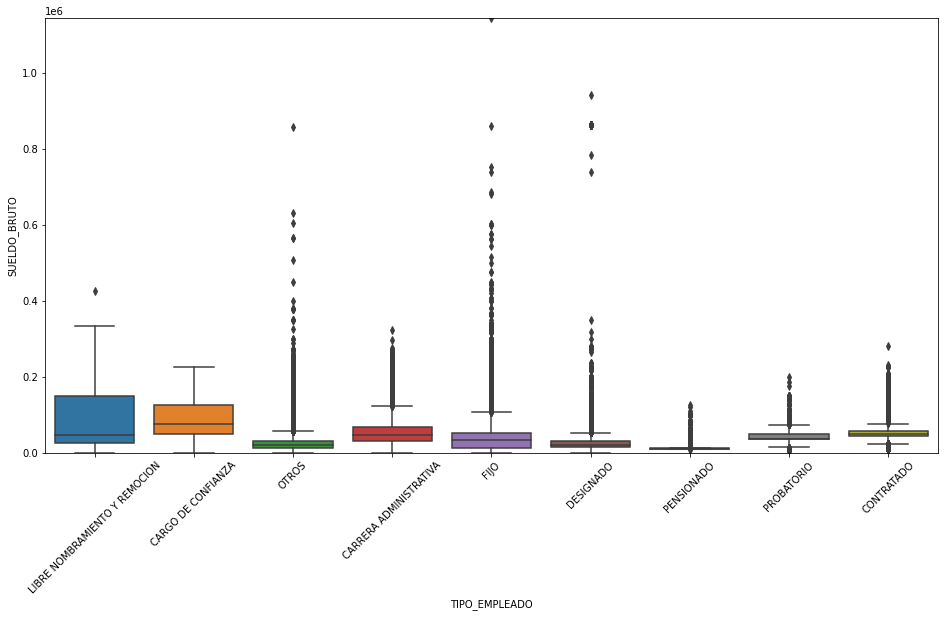

In [13]:
### En este grafico de Correlacion podemos ver los sueldos agrupados por Tipo de Empleado. Viendo mas de cerca los datos atipicos.

var = 'TIPO_EMPLEADO'
max_s = df['SUELDO_BRUTO'].max()
data = pd.concat([df['SUELDO_BRUTO'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SUELDO_BRUTO", data=data)
fig.axis(ymin=0, ymax=max_s);
plt.xticks(rotation=45);

# Analisis Descriptivo y Exploratorio (EDA)

                                             |          | [  0%]   00:00 -> (? left)

Report Report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



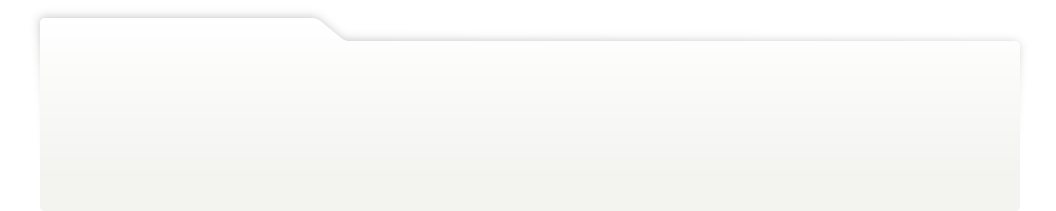
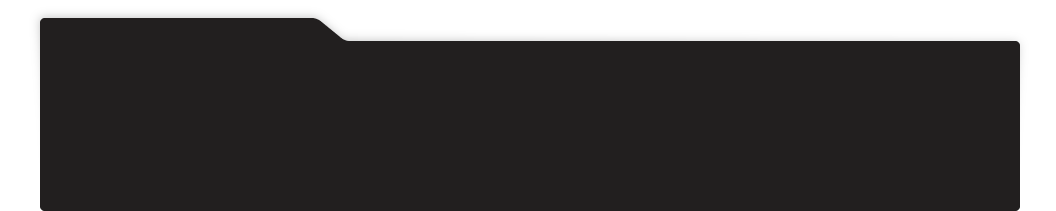
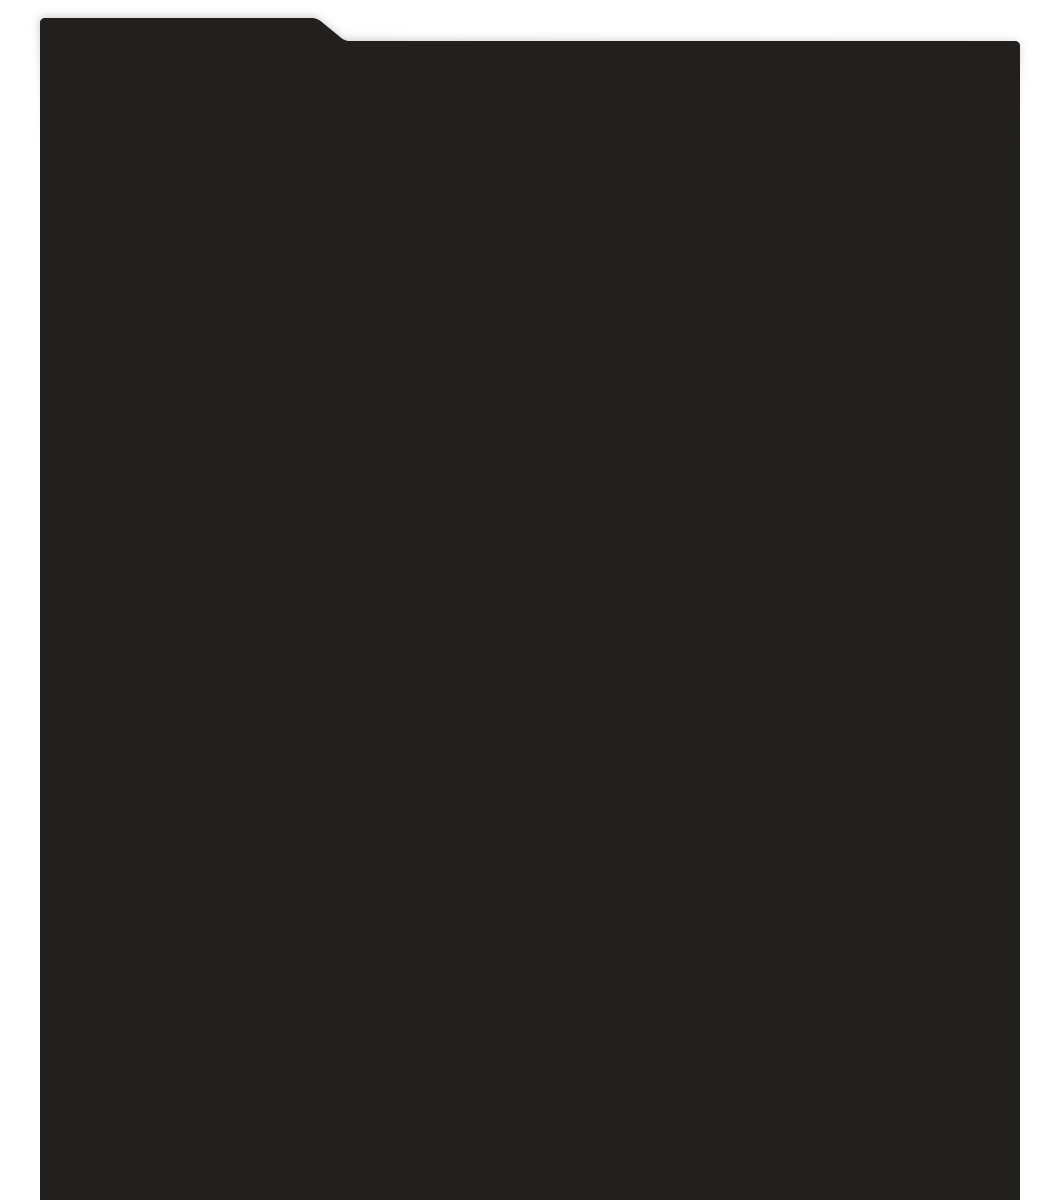
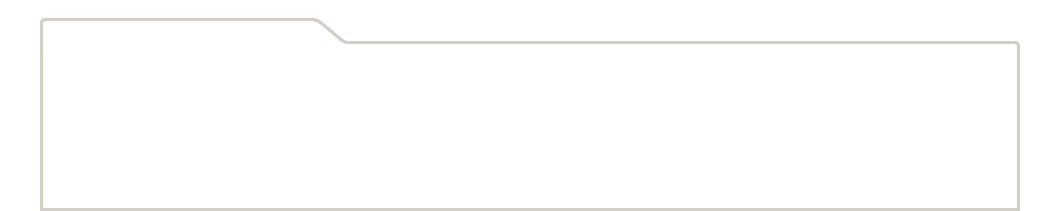
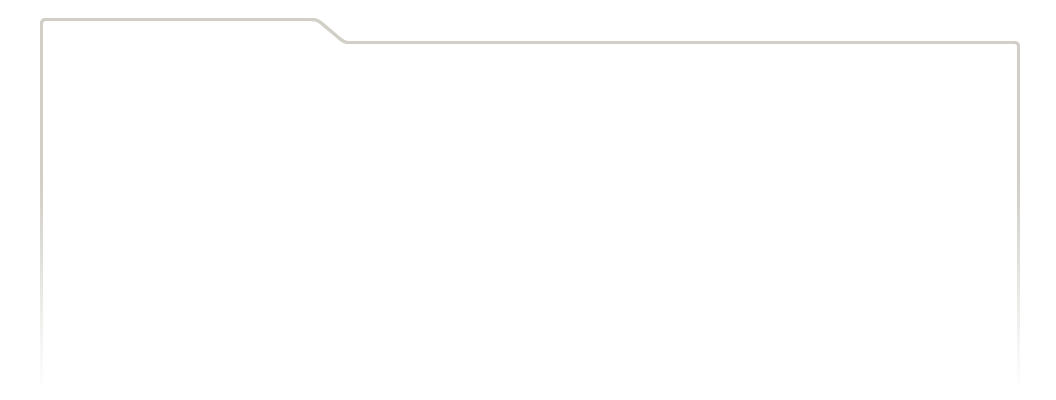
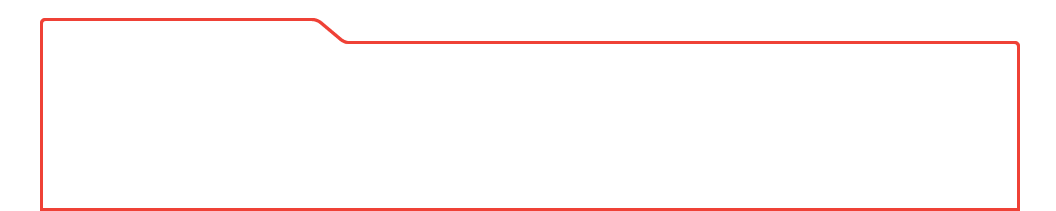
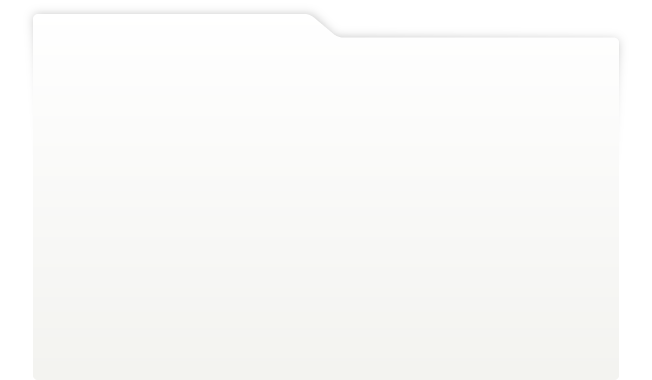
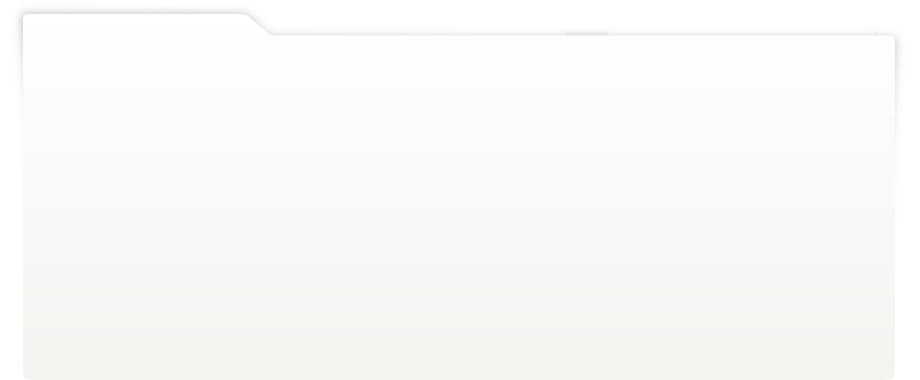
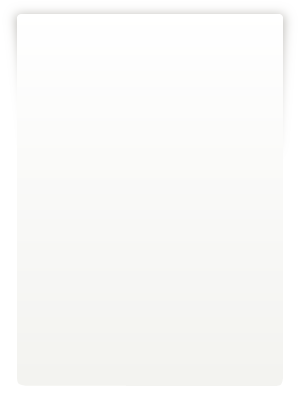
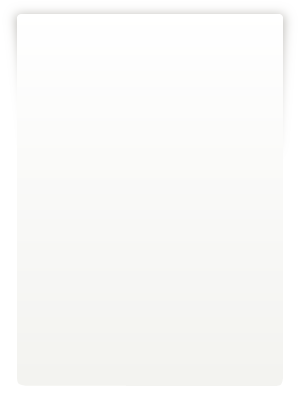
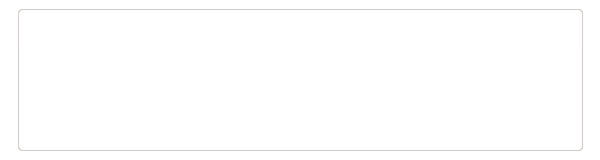
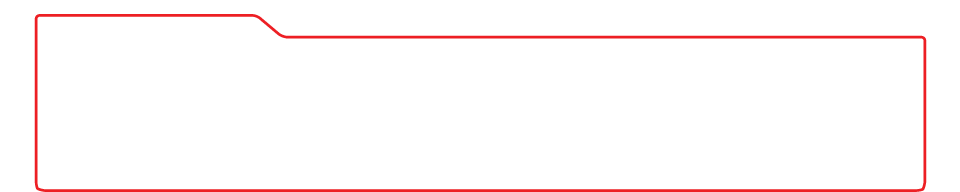
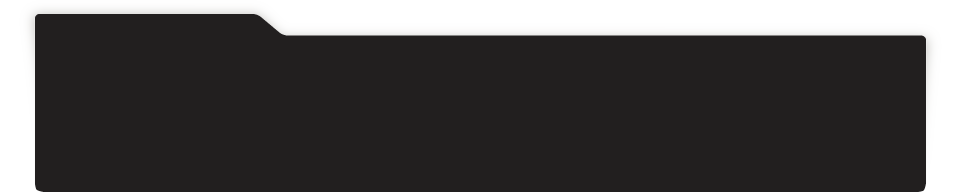
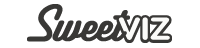
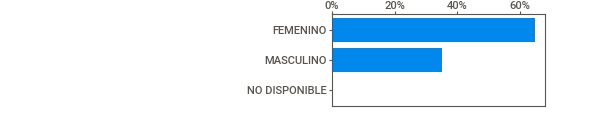
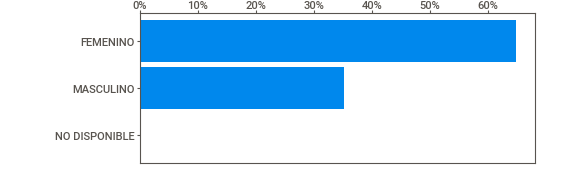
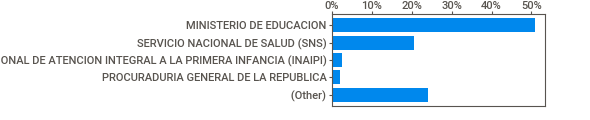
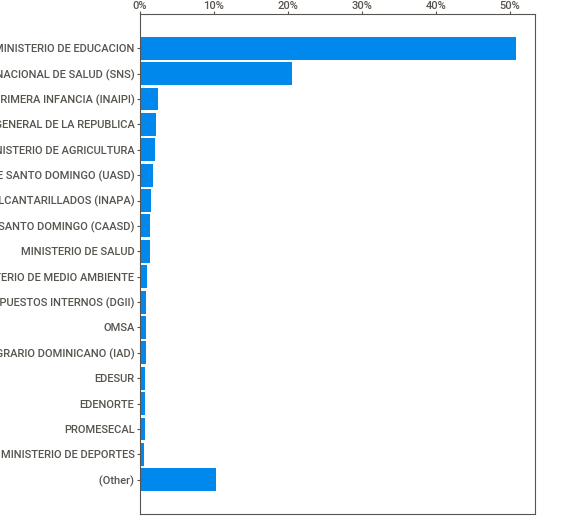
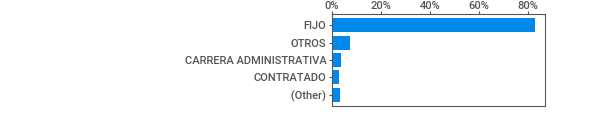
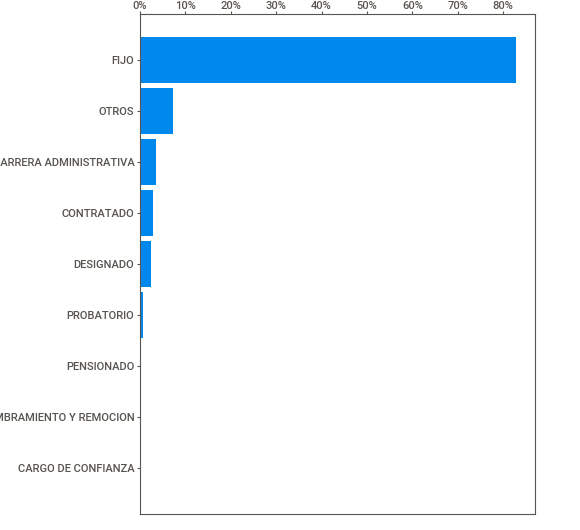
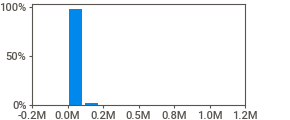
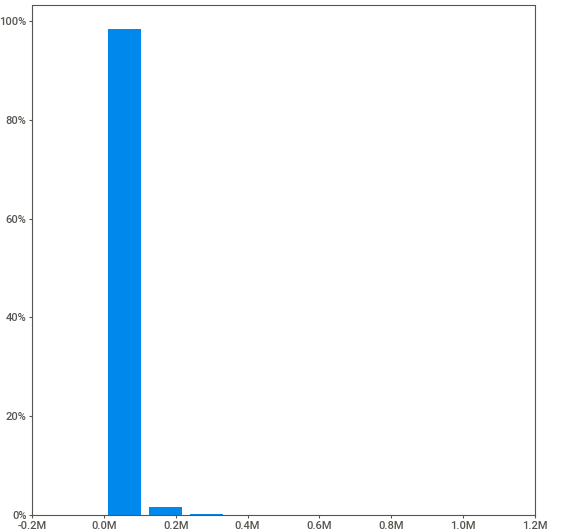
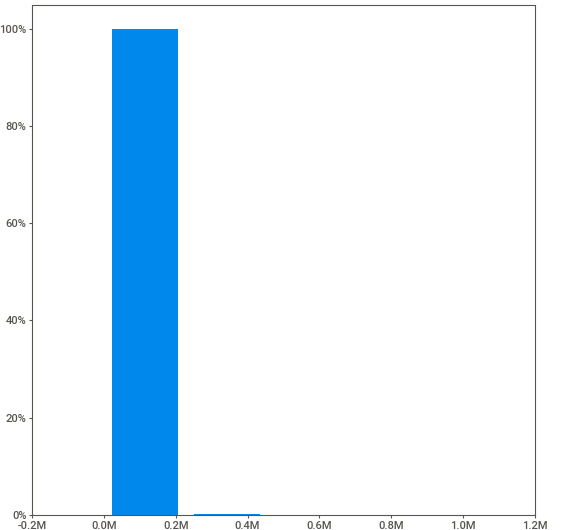
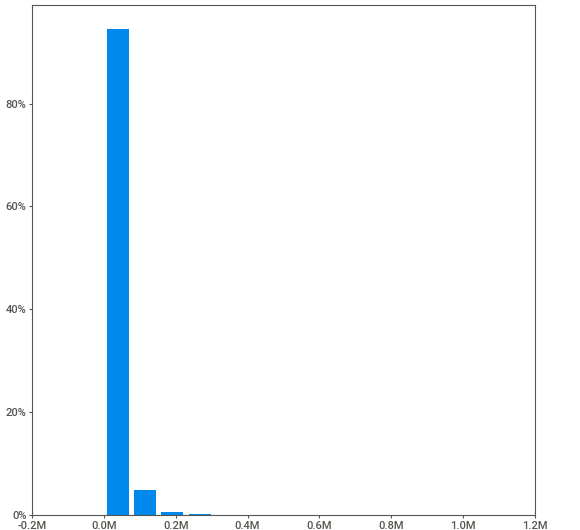
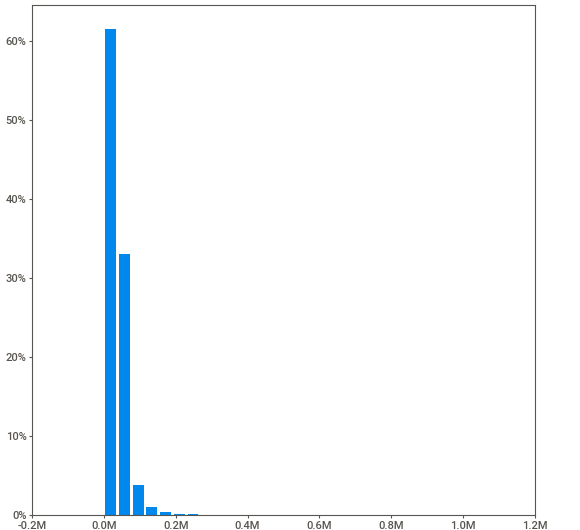
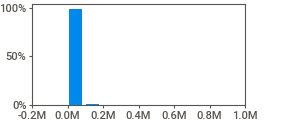
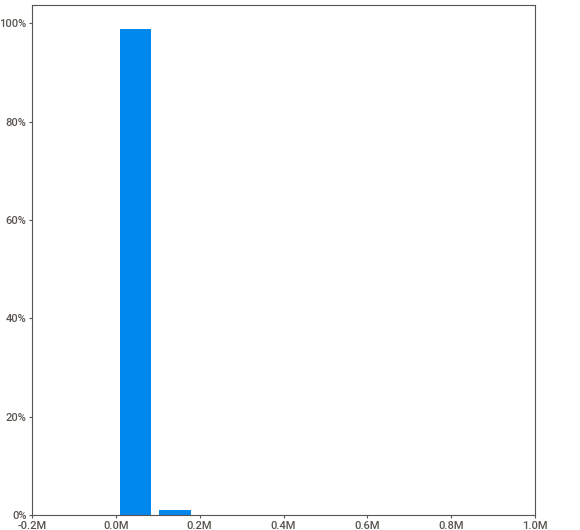
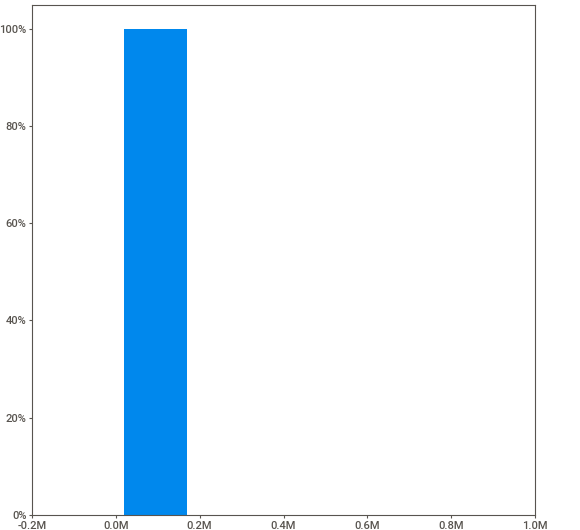
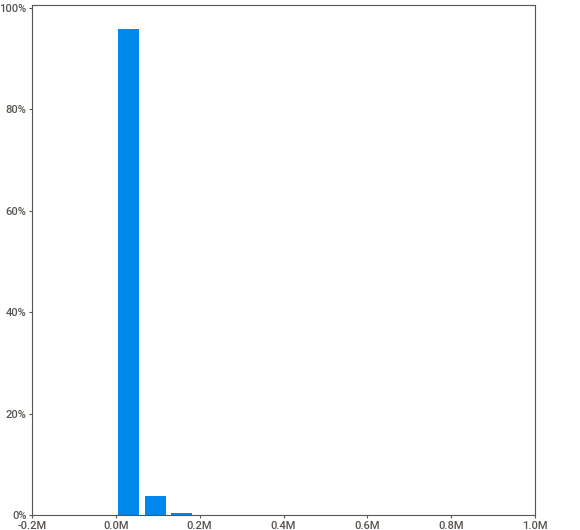
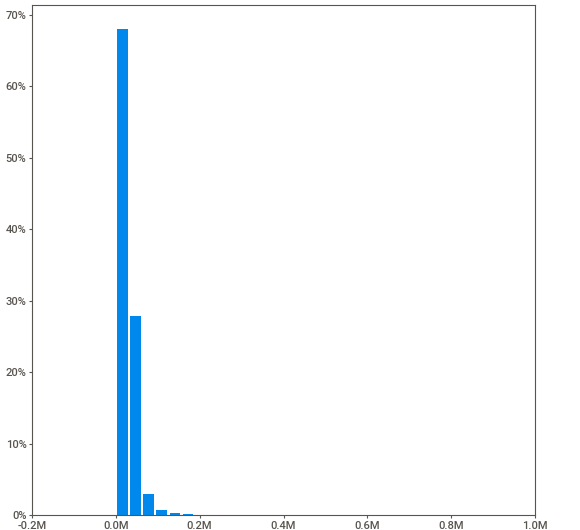
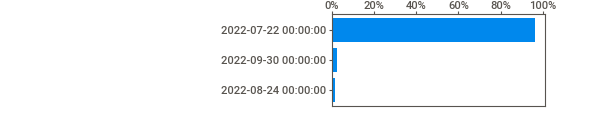
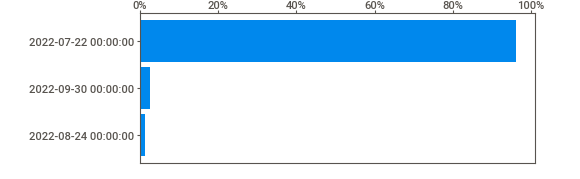
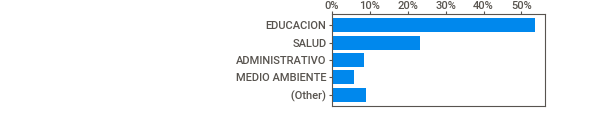
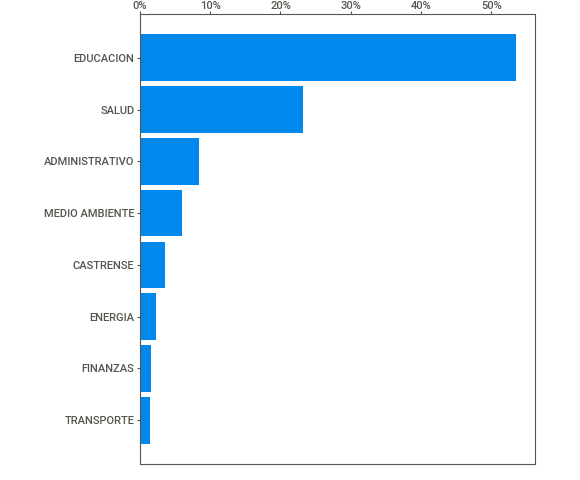
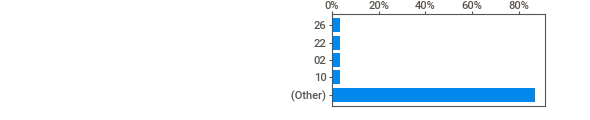
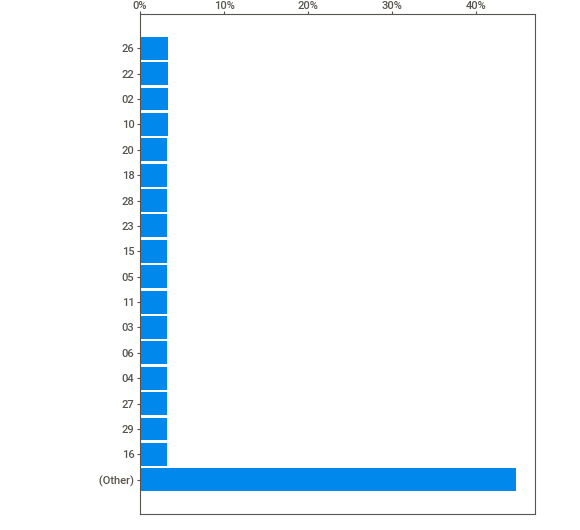
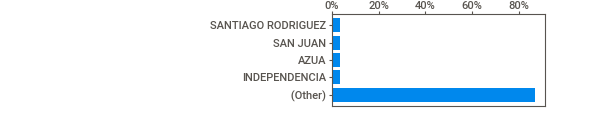
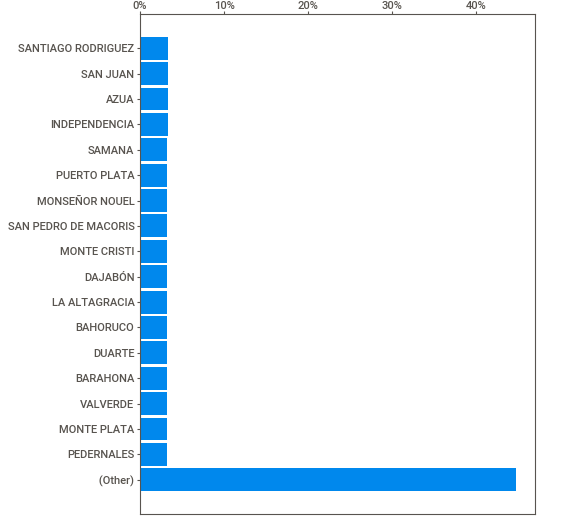
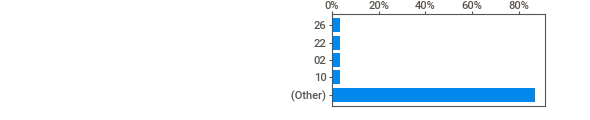
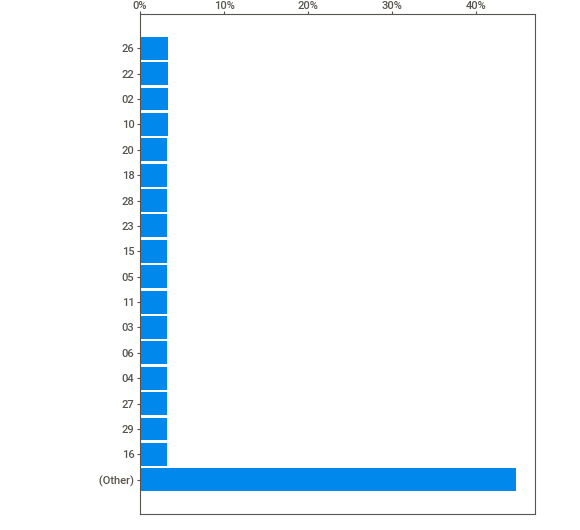
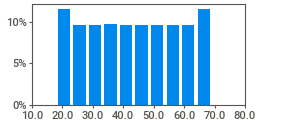
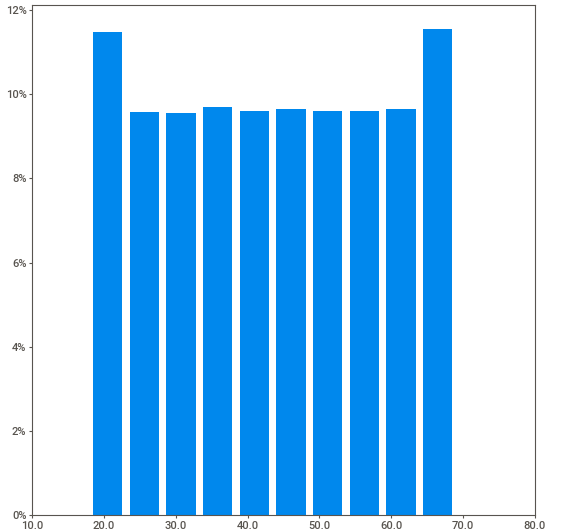
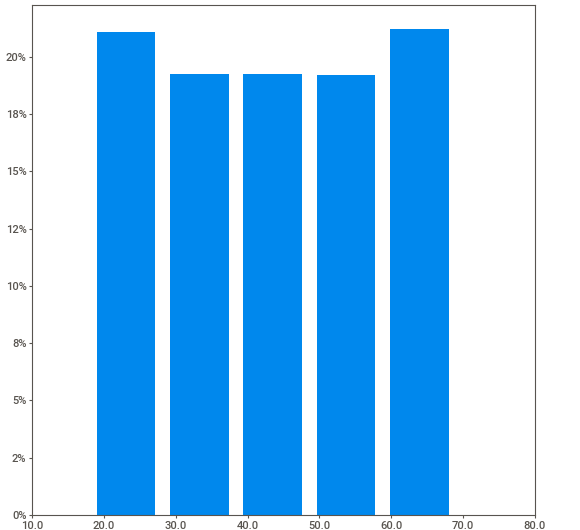
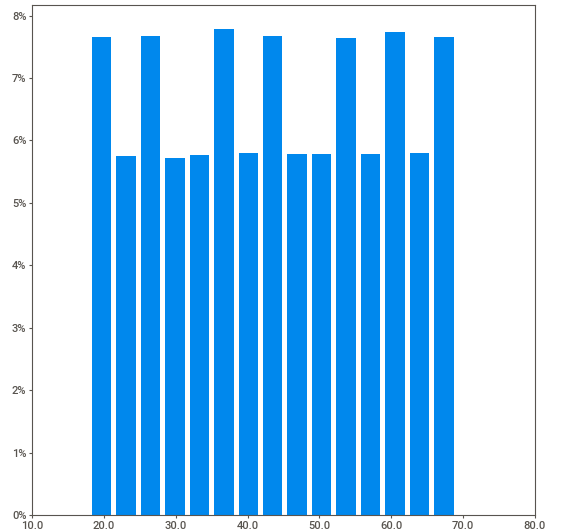
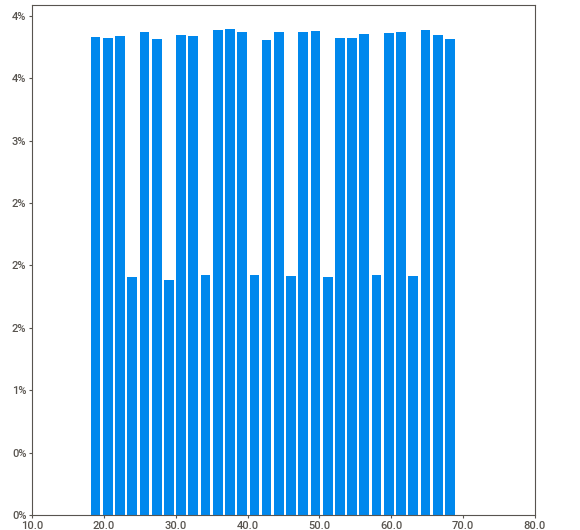
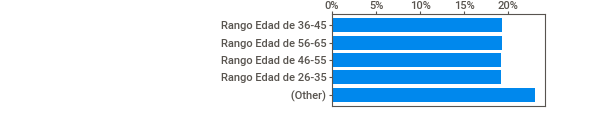
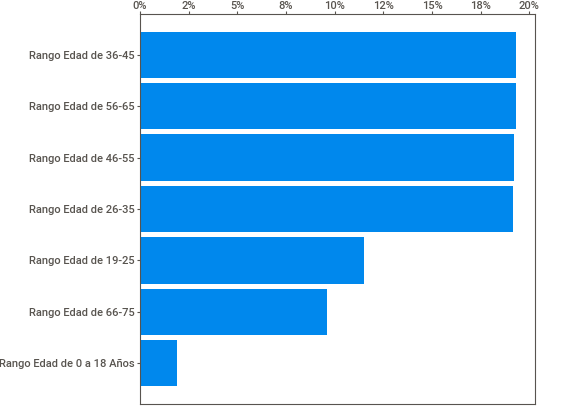
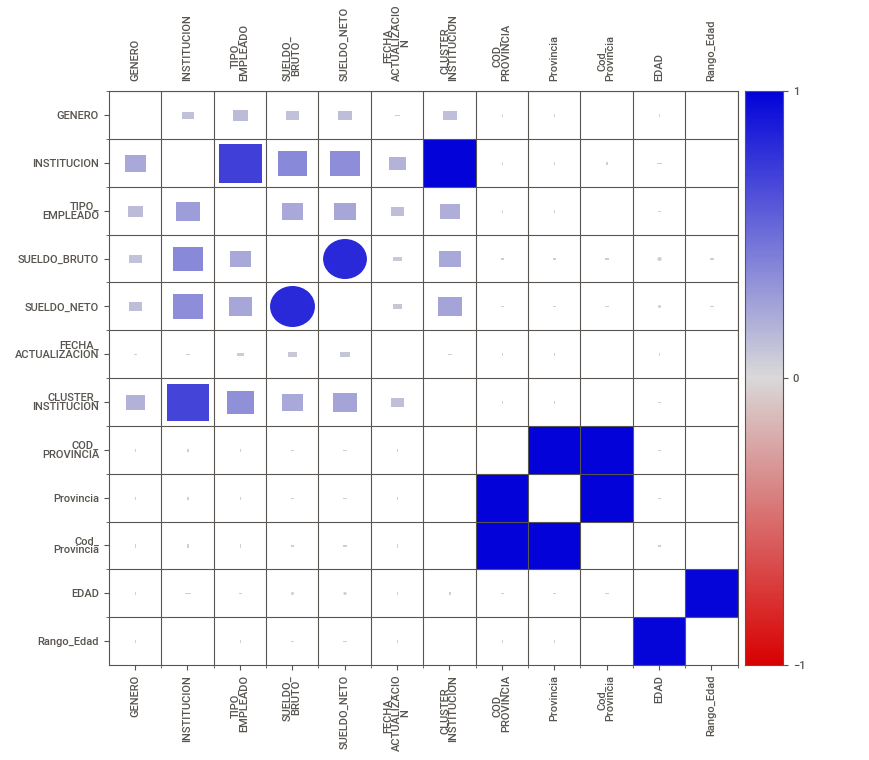
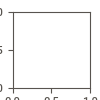

CPU times: user 1min 41s, sys: 9.09 s, total: 1min 50s
Wall time: 1min 40s


In [14]:
%%time
## Con la Libreria de SweetViz realizamos un analisis descriptivo y de correlacion de nuestro Dataframe.

my_report = sv.analyze(df)
my_report.show_html('Report.html')
my_report.show_notebook()

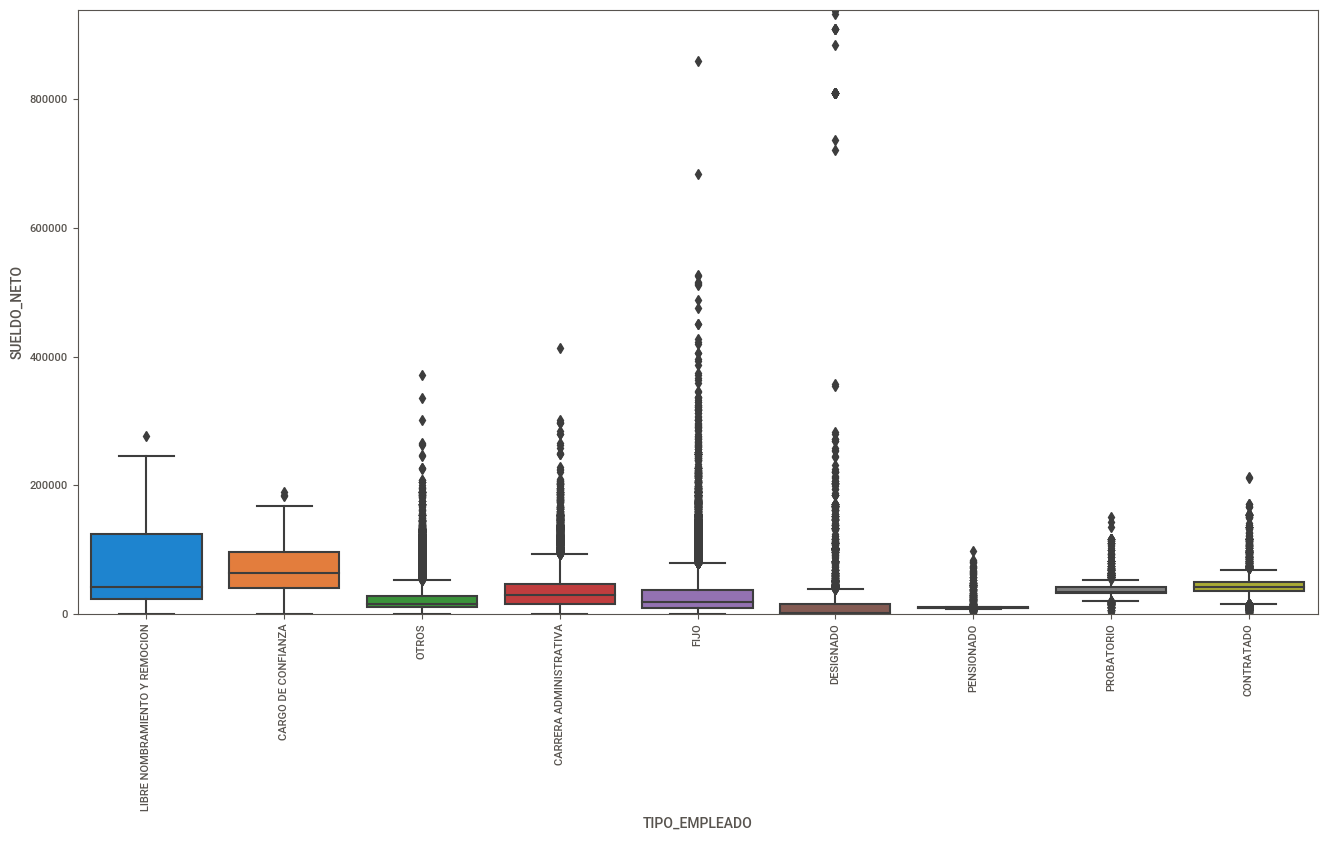

In [15]:
var = 'TIPO_EMPLEADO'
max_s = df['SUELDO_NETO'].max()
data = pd.concat([df['SUELDO_NETO'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SUELDO_NETO", data=data)
fig.axis(ymin=0, ymax=max_s);
plt.xticks(rotation=90);

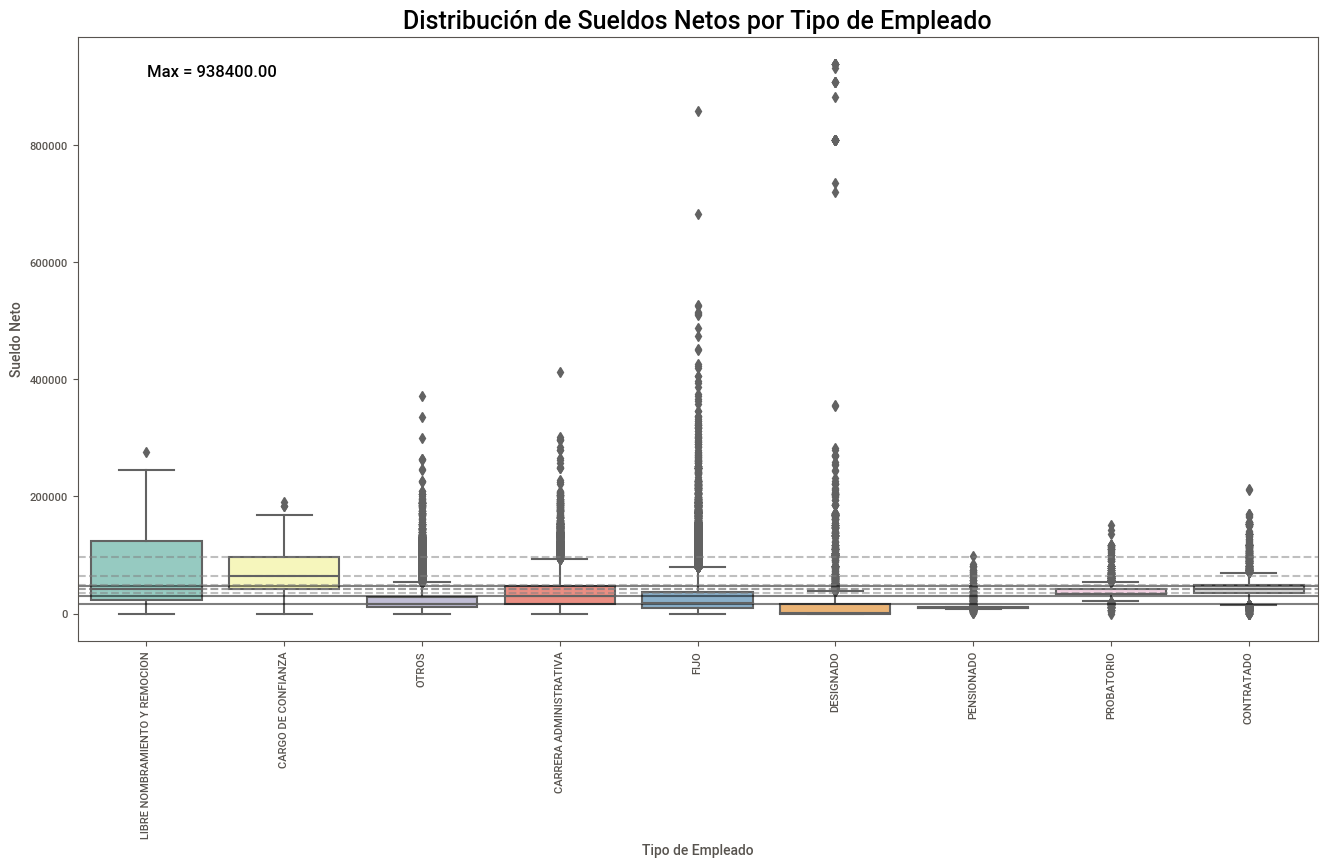

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

var = 'TIPO_EMPLEADO'
max_s = df['SUELDO_NETO'].max()

# Agregar etiquetas a los ejes x e y
data = pd.concat([df['SUELDO_NETO'], df[var]], axis=1)
data.columns = ['Sueldo Neto', 'Tipo de Empleado']

# Crear un gráfico de caja mejorado
f, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x='Tipo de Empleado', y='Sueldo Neto', data=data, palette='Set3')

# Agregar título y ajustar el tamaño de la fuente
plt.title('Distribución de Sueldos Netos por Tipo de Empleado', fontsize=18)

# Agregar líneas horizontales para los percentiles
pctls = data.groupby('Tipo de Empleado')['Sueldo Neto'].quantile([0.25, 0.5, 0.75]).unstack()
for i, pctl in enumerate(pctls):
    plt.axhline(pctls[pctl].iloc[0], color='gray', linestyle='--', alpha=0.5)
    plt.axhline(pctls[pctl].iloc[1], color='black', linestyle='-', alpha=0.5)
    plt.axhline(pctls[pctl].iloc[2], color='gray', linestyle='--', alpha=0.5)

# Agregar el valor máximo del sueldo neto
plt.text(0.95, max_s, f'Max = {max_s:.2f}', horizontalalignment='right', verticalalignment='top', fontsize=12)

# Rotar las etiquetas del eje x
plt.xticks(rotation=90)

# Mostrar el gráfico
plt.show()


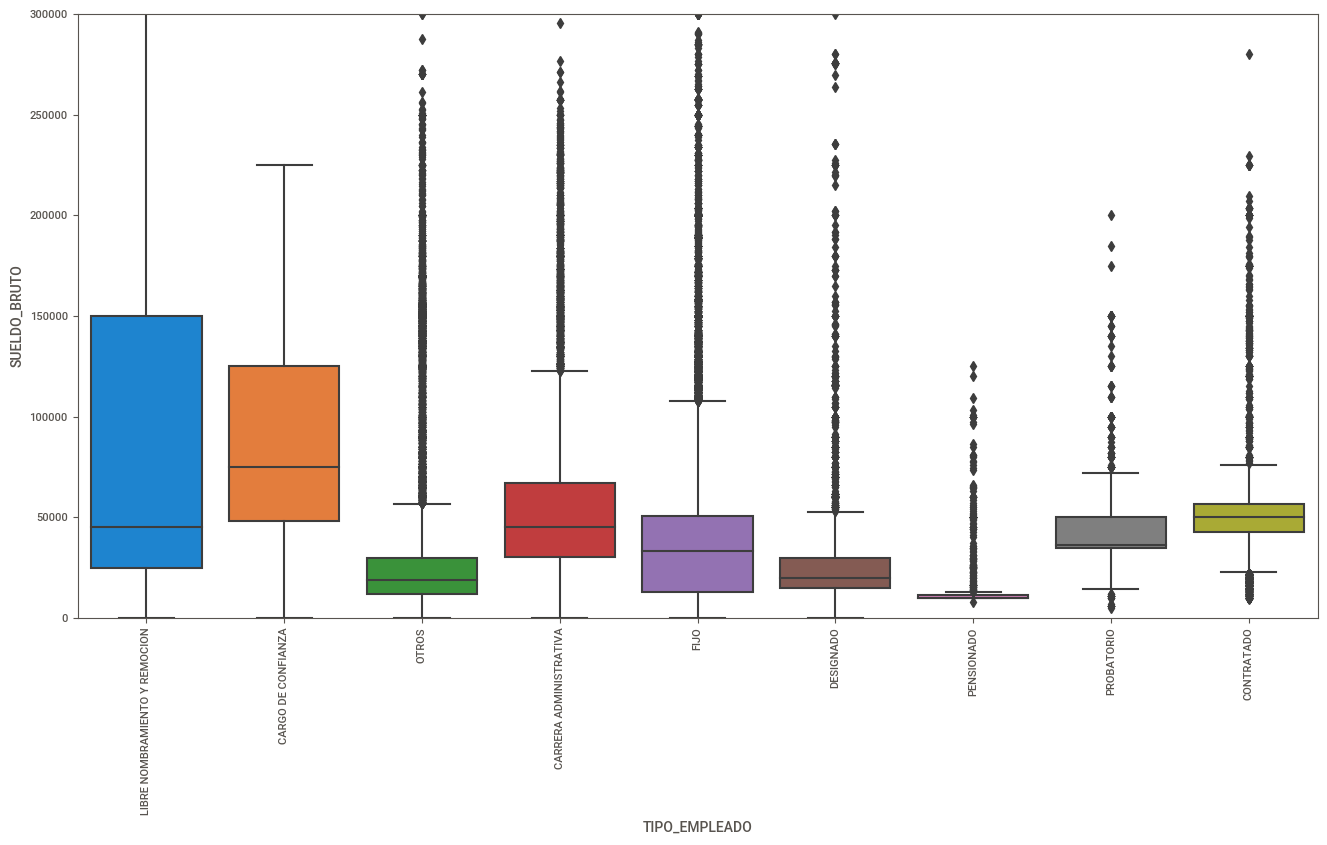

In [17]:
var = 'TIPO_EMPLEADO'
max_s = df['SUELDO_BRUTO'].max()
data = pd.concat([df['SUELDO_BRUTO'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SUELDO_BRUTO", data=data)
fig.axis(ymin=0, ymax=300000);
plt.xticks(rotation=90);

# Normalizacion de la Variable Sueldo Bruto

### Con estas funciones estaremos detectando los outliers y reemplazandolo por los valores de la mediana, siendo el caso esten por encima de los valores tipicos. Esto, agrupandolos por la variable Tipo de Empleado.

In [18]:
%%time

def asig_mean_sueldo (df):
    
    if df['TIPO_EMPLEADO'] == 'CARGO DE CONFIANZA':
        return 89656.80
    elif df['TIPO_EMPLEADO'] == 'CARRERA ADMINISTRATIVA':
        return 62887.25
    elif df['TIPO_EMPLEADO'] == 'CONTRATADO':
        return 49146.97
    elif df['TIPO_EMPLEADO'] == 'DESIGNADO':
        return 25165.50
    elif df['TIPO_EMPLEADO'] == 'FIJO':
        return 35337.49
    elif df['TIPO_EMPLEADO'] == 'LIBRE NOMBRAMIENTO Y REMOCION':
        return 89621.34
    elif df['TIPO_EMPLEADO'] == 'OTROS':
        return 34950.49
    elif df['TIPO_EMPLEADO'] == 'PENSIONADO':
        return 18057.73
    elif df['TIPO_EMPLEADO'] == 'PENSIONADO':
        return 42732.24
    else:
        return 0.0
    
df['validacion_prom_sueldo'] = df.apply(asig_mean_sueldo, axis = 1)

def asig_std_sueldo (df):
    
    if df['TIPO_EMPLEADO'] == 'CARGO DE CONFIANZA':
        return 52153.691242
    elif df['TIPO_EMPLEADO'] == 'CARRERA ADMINISTRATIVA':
        return 46295.284673
    elif df['TIPO_EMPLEADO'] == 'CONTRATADO':
        return 20271.566289
    elif df['TIPO_EMPLEADO'] == 'DESIGNADO':
        return 32647.894459
    elif df['TIPO_EMPLEADO'] == 'FIJO':
        return 25293.993622
    elif df['TIPO_EMPLEADO'] == 'LIBRE NOMBRAMIENTO Y REMOCION':
        return 88471.470558
    elif df['TIPO_EMPLEADO'] == 'OTROS':
        return 37001.931032
    elif df['TIPO_EMPLEADO'] == 'PENSIONADO':
        return 19058.436992
    elif df['TIPO_EMPLEADO'] == 'PENSIONADO':
        return 18005.772377
    else:
        return 0.0
df['validacion_std_sueldo'] = df.apply(asig_std_sueldo, axis = 1)


gb_df = df.groupby(['TIPO_EMPLEADO']).SUELDO_BRUTO.agg([np.mean])\
.rename(columns={'mean': 'Sueldo'})


gb_df = df.groupby(['TIPO_EMPLEADO']).SUELDO_BRUTO.agg([np.std])\
.rename(columns={'std': 'Sueldo'})

df['outliers'] = (df['SUELDO_BRUTO']-df['validacion_prom_sueldo']).abs() > 2*df['validacion_std_sueldo']

def reempl_outliers (df):
    if df['outliers'] == True:
        return df['validacion_prom_sueldo']
    else:
        return df['SUELDO_BRUTO']
    
df['SUELDO_BRUTO'] = df.apply(reempl_outliers, axis = 1)


CPU times: user 35.8 s, sys: 600 ms, total: 36.4 s
Wall time: 36.4 s


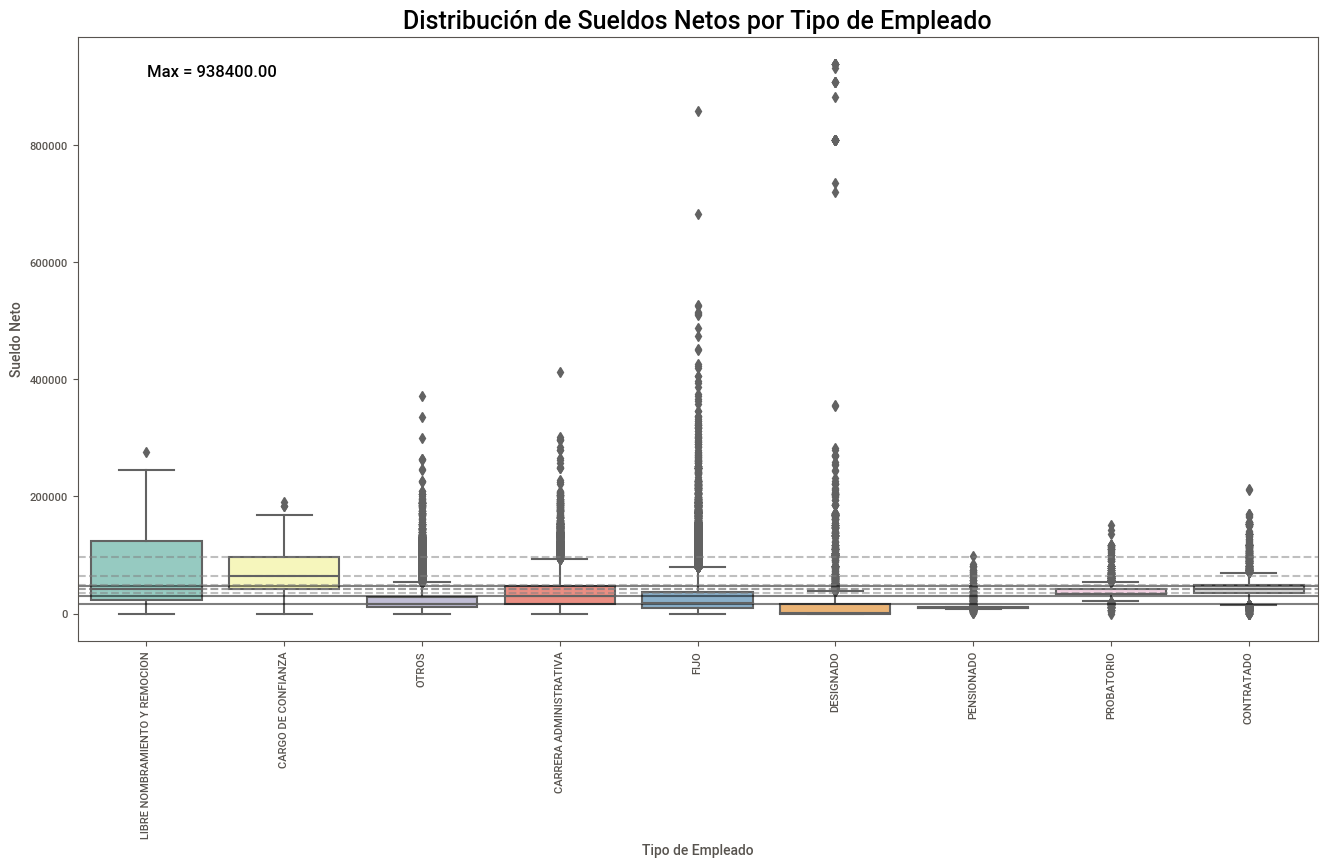

In [19]:
#Aqui vemos los valores ya normalizados sin los datos atipicos por encima de la mediana. Ya aplicadas las funciones.
import matplotlib.pyplot as plt
import seaborn as sns

var = 'TIPO_EMPLEADO'
max_s = df['SUELDO_NETO'].max()

# Agregar etiquetas a los ejes x e y
data = pd.concat([df['SUELDO_NETO'], df[var]], axis=1)
data.columns = ['Sueldo Neto', 'Tipo de Empleado']

# Crear un gráfico de caja mejorado
f, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x='Tipo de Empleado', y='Sueldo Neto', data=data, palette='Set3')

# Agregar título y ajustar el tamaño de la fuente
plt.title('Distribución de Sueldos Netos por Tipo de Empleado', fontsize=18)

# Agregar líneas horizontales para los percentiles
pctls = data.groupby('Tipo de Empleado')['Sueldo Neto'].quantile([0.25, 0.5, 0.75]).unstack()
for i, pctl in enumerate(pctls):
    plt.axhline(pctls[pctl].iloc[0], color='gray', linestyle='--', alpha=0.5)
    plt.axhline(pctls[pctl].iloc[1], color='black', linestyle='-', alpha=0.5)
    plt.axhline(pctls[pctl].iloc[2], color='gray', linestyle='--', alpha=0.5)

# Agregar el valor máximo del sueldo neto
plt.text(0.95, max_s, f'Max = {max_s:.2f}', horizontalalignment='right', verticalalignment='top', fontsize=12)

# Rotar las etiquetas del eje x
plt.xticks(rotation=90)

# Mostrar el gráfico
plt.show()


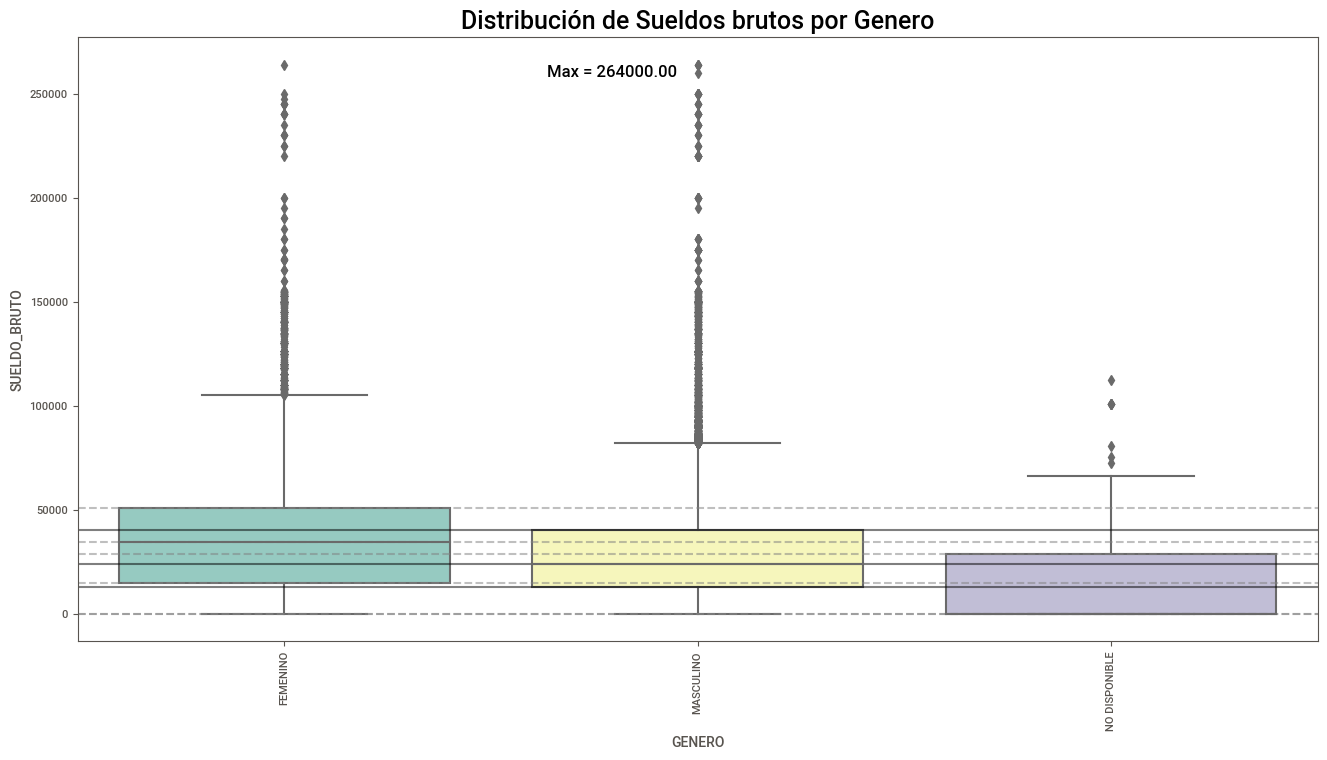

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

var = 'GENERO'
max_s = df['SUELDO_BRUTO'].max()

# Agregar etiquetas a los ejes x e y
data = pd.concat([df['SUELDO_BRUTO'], df[var]], axis=1)
data.columns = ['SUELDO_BRUTO', 'GENERO']

# Crear un gráfico de caja mejorado
f, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x='GENERO', y='SUELDO_BRUTO', data=data, palette='Set3')

# Agregar título y ajustar el tamaño de la fuente
plt.title('Distribución de Sueldos brutos por Genero', fontsize=18)

# Agregar líneas horizontales para los percentiles
pctls = data.groupby('GENERO')['SUELDO_BRUTO'].quantile([0.25, 0.5, 0.75]).unstack()
for i, pctl in enumerate(pctls):
    plt.axhline(pctls[pctl].iloc[0], color='gray', linestyle='--', alpha=0.5)
    plt.axhline(pctls[pctl].iloc[1], color='black', linestyle='-', alpha=0.5)
    plt.axhline(pctls[pctl].iloc[2], color='gray', linestyle='--', alpha=0.5)

# Agregar el valor máximo del sueldo neto
plt.text(0.95, max_s, f'Max = {max_s:.2f}', horizontalalignment='right', verticalalignment='top', fontsize=12)

# Rotar las etiquetas del eje x
plt.xticks(rotation=90)

# Mostrar el gráfico
plt.show()


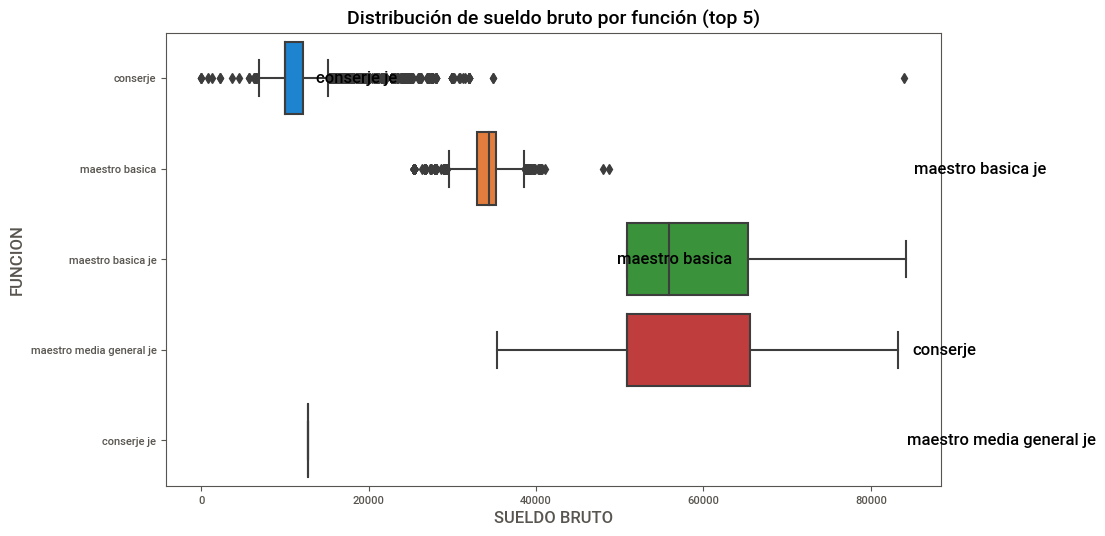

In [21]:
# Obtener los 5 cargos más comunes
top_cargo = df["FUNCION"].value_counts().sort_values(ascending=False).head(5).index.values

# Crear un subplot con Seaborn
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(y="FUNCION", x="SUELDO_BRUTO", data=df[df["FUNCION"].isin(top_cargo)], orient="h", ax=ax)

# Configurar los ejes
ax.set_xlabel("SUELDO BRUTO", fontsize=12)
ax.set_ylabel("FUNCION", fontsize=12)
ax.set_title("Distribución de sueldo bruto por función (top 5)", fontsize=14)

# Añadir etiquetas para cada caja
for i in range(len(top_cargo)):
    cargo = top_cargo[i]
    ax.text(
        x=df[df["FUNCION"] == cargo]["SUELDO_BRUTO"].max() + 1000, 
        y=i, 
        s=cargo, 
        color="black", 
        fontsize=12, 
        verticalalignment="center"
    )

# Mostrar el plot
plt.show()

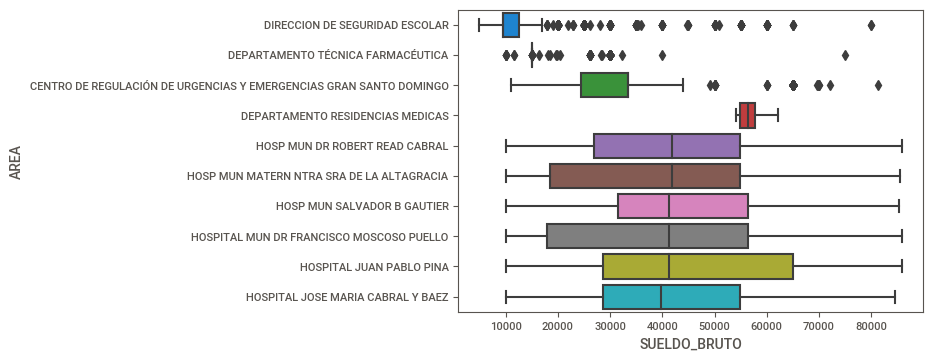

In [22]:
med_1 = "AREA"
med_2 = "SUELDO_BRUTO"
top = (
    df[med_1].value_counts().sort_values(ascending=False).head(10).index.values
)
sns.boxplot(
    y=med_1,
    x=med_2,
    data=df[df[med_1].isin(top)],
    orient="h",
);

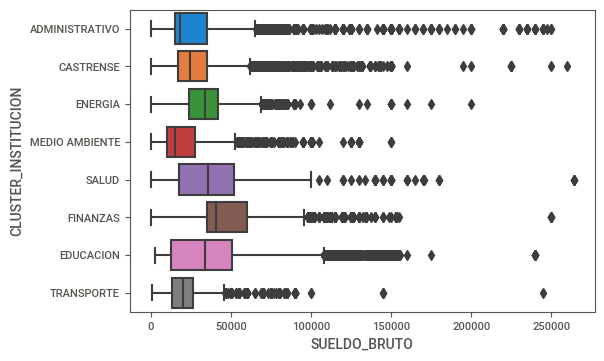

In [23]:
med_1 = "CLUSTER_INSTITUCION"
med_2 = "SUELDO_BRUTO"
top = (
    df[med_1].value_counts().sort_values(ascending=False).head(10).index.values
)
sns.boxplot(
    y=med_1,
    x=med_2,
    data=df[df[med_1].isin(top)],
    orient="h",
);

In [24]:
gb_df = df.groupby(['TIPO_EMPLEADO']).SUELDO_BRUTO.agg([len, np.min,\
                                                               np.max,np.mean,np.std]).rename(columns={'len': 'Cant. Empleados',\
                                                                                                'amin': 'Sueldo Minimo',\
                                                                                               'amax': 'Sueldo Maximo',\
                                                                                               'mean': 'Sueldo Promedio',\
                                                                                                'std': 'Desviacion Estandar'})

gb_df['Sueldo Promedio'] = gb_df['Sueldo Promedio'].round()

gb_df['Sueldo Maximo'] = gb_df['Sueldo Maximo'].round()
gb_df['Sueldo Maximo'] = gb_df['Sueldo Maximo'].apply('{:,}'.format)

gb_df['Sueldo Minimo'] = gb_df['Sueldo Minimo'].round()
gb_df['Sueldo Minimo'] = gb_df['Sueldo Minimo'].apply('{:,}'.format)

gb_df['Desviacion Estandar'] = gb_df['Desviacion Estandar'].round()
gb_df['Desviacion Estandar'] = gb_df['Desviacion Estandar'].apply('{:,}'.format)

gb_df['Cant. Empleados'] = gb_df['Cant. Empleados'].apply('{:,}'.format)

gb_df.head(10).sort_values(by='Sueldo Promedio', ascending=False )
gb_df

,Cant. Empleados,Sueldo Minimo,Sueldo Maximo,Sueldo Promedio,Desviacion Estandar
TIPO_EMPLEADO,,,,,
CARGO DE CONFIANZA,415,0.0,"190,000.0",82022.0,"43,415.0"
CARRERA ADMINISTRATIVA,"14,667",0.0,"155,369.0",50641.0,"28,530.0"
CONTRATADO,"11,400","9,313.0","89,480.0",46743.0,"13,503.0"
DESIGNADO,"10,212",0.0,"90,200.0",23163.0,"12,561.0"
FIJO,"342,222",0.0,"85,920.0",33700.0,"20,602.0"
LIBRE NOMBRAMIENTO Y REMOCION,478,0.0,"264,000.0",85908.0,"76,780.0"
OTROS,"30,441",0.0,"108,861.0",24592.0,"18,280.0"
PENSIONADO,787,"8,050.0","55,900.0",14501.0,"10,452.0"
PROBATORIO,"2,321",0.0,0.0,0.0,0.0


In [25]:
gb_df = df.groupby(['INSTITUCION']).SUELDO_BRUTO.agg([len, np.min,\
                                                               np.max,np.mean,np.std]).rename(columns={'len': 'Cant. Empleados',\
                                                                                                'amin': 'Sueldo Minimo',\
                                                                                               'amax': 'Sueldo Maximo',\
                                                                                               'mean': 'Sueldo Promedio',\
                                                                                                'std': 'Desviacion Estandar'})

gb_df['Sueldo Promedio'] = gb_df['Sueldo Promedio'].round()

gb_df['Sueldo Maximo'] = gb_df['Sueldo Maximo'].round()
gb_df['Sueldo Maximo'] = gb_df['Sueldo Maximo'].apply('{:,}'.format)

gb_df['Sueldo Minimo'] = gb_df['Sueldo Minimo'].round()
gb_df['Sueldo Minimo'] = gb_df['Sueldo Minimo'].apply('{:,}'.format)

gb_df['Desviacion Estandar'] = gb_df['Desviacion Estandar'].round()
gb_df['Desviacion Estandar'] = gb_df['Desviacion Estandar'].apply('{:,}'.format)

gb_df['Cant. Empleados'] = gb_df['Cant. Empleados'].apply('{:,}'.format)


gb_df.sort_values(by='Sueldo Promedio', ascending=False )

,Cant. Empleados,Sueldo Minimo,Sueldo Maximo,Sueldo Promedio,Desviacion Estandar
INSTITUCION,,,,,
MINISTERIO DE ADMINISTRACION PUBLICA (MAP),312,0.0,"245,000.0",61077.0,"36,036.0"
DIRECCION GENERAL DE PRESUPUESTO,226,"19,200.0","245,000.0",57251.0,"32,637.0"
DIRECCION GENERAL DE CONTRATACIONES PUBLICAS,147,"15,000.0","245,000.0",56733.0,"37,265.0"
SUPERINTENDENCIA DE BANCOS,4,"35,337.0","75,107.0",55908.0,"22,198.0"
INSTITUTO DOMINICANO DE AVIACION CIVIL (IDAC),"1,954",1.0,"260,000.0",55394.0,"34,547.0"
...,...,...,...,...,...
INSTITUTO NACIONAL DE ATENCION INTEGRAL A LA PRIMERA INFANCIA (INAIPI),"10,095",605.0,"247,500.0",18584.0,"8,836.0"
DEFENSA CIVIL,399,"10,000.0","200,000.0",17757.0,"15,885.0"
OMSA,"3,139","10,000.0","245,000.0",17646.0,"9,485.0"


In [26]:
gb_df = df.groupby(['FUNCION']).SUELDO_BRUTO.agg([len, np.min,\
                                                               np.max,np.mean,np.std]).rename(columns={'len': 'Cant. Empleados',\
                                                                                                'amin': 'Sueldo Minimo',\
                                                                                               'amax': 'Sueldo Maximo',\
                                                                                               'mean': 'Sueldo Promedio',\
                                                                                                'std': 'Desviacion Estandar'})

gb_df['Sueldo Promedio'] = gb_df['Sueldo Promedio'].round()

gb_df['Sueldo Maximo'] = gb_df['Sueldo Maximo'].round()
gb_df['Sueldo Maximo'] = gb_df['Sueldo Maximo'].apply('{:,}'.format)

gb_df['Sueldo Minimo'] = gb_df['Sueldo Minimo'].round()
gb_df['Sueldo Minimo'] = gb_df['Sueldo Minimo'].apply('{:,}'.format)

gb_df['Desviacion Estandar'] = gb_df['Desviacion Estandar'].round()
gb_df['Desviacion Estandar'] = gb_df['Desviacion Estandar'].apply('{:,}'.format)



gb_df.head(25).sort_values(by='Sueldo Promedio', ascending=False )


,Cant. Empleados,Sueldo Minimo,Sueldo Maximo,Sueldo Promedio,Desviacion Estandar
FUNCION,,,,,
75% carga docente (doc inv y e,12,"62,887.0","153,914.0",100015.0,"39,372.0"
abogada regularizacion de inmuebles,1,"84,000.0","84,000.0",84000.0,nan
abogada de contratos y ejecucion,1,"84,000.0","84,000.0",84000.0,nan
abogado (a) de litigios,1,"82,350.0","82,350.0",82350.0,nan
50% carga docente (doc inv y e,22,"34,950.0","154,263.0",80736.0,"43,389.0"
abogada ii,6,"60,000.0","80,000.0",63333.0,"8,165.0"
abogada,26,"20,350.0","91,500.0",57371.0,"18,323.0"
abogada 2,3,"40,500.0","60,000.0",53500.0,"11,258.0"
abogada i opm bonao-mosnouel,1,"50,000.0","50,000.0",50000.0,nan


In [27]:
gb_df = df.groupby(['GENERO']).SUELDO_BRUTO.agg([len, np.min,\
                                                               np.max,np.mean]).rename(columns={'len': 'Cant. Empleados',\
                                                                                                'amin': 'Sueldo Minimo',\
                                                                                               'amax': 'Sueldo Maximo',\
                                                                                               'mean': 'Sueldo Promedio'})


gb_df['Sueldo Promedio'] = gb_df['Sueldo Promedio'].round()
gb_df['Sueldo Promedio'] = gb_df['Sueldo Promedio'].apply('{:,}'.format)

gb_df['Sueldo Maximo'] = gb_df['Sueldo Maximo'].round()
gb_df['Sueldo Maximo'] = gb_df['Sueldo Maximo'].apply('{:,}'.format)

gb_df['Sueldo Minimo'] = gb_df['Sueldo Minimo'].round()
gb_df['Sueldo Minimo'] = gb_df['Sueldo Minimo'].apply('{:,}'.format)


gb_df['Cant. Empleados'] = gb_df['Cant. Empleados'].apply('{:,}'.format)


gb_df.head(10).sort_values(by='Sueldo Promedio', ascending=False )



,Cant. Empleados,Sueldo Minimo,Sueldo Maximo,Sueldo Promedio
GENERO,,,,
FEMENINO,"261,686",0.0,"264,000.0","35,647.0"
MASCULINO,"141,561",0.0,"264,000.0","29,948.0"
NO DISPONIBLE,183,0.0,"112,192.0","13,599.0"


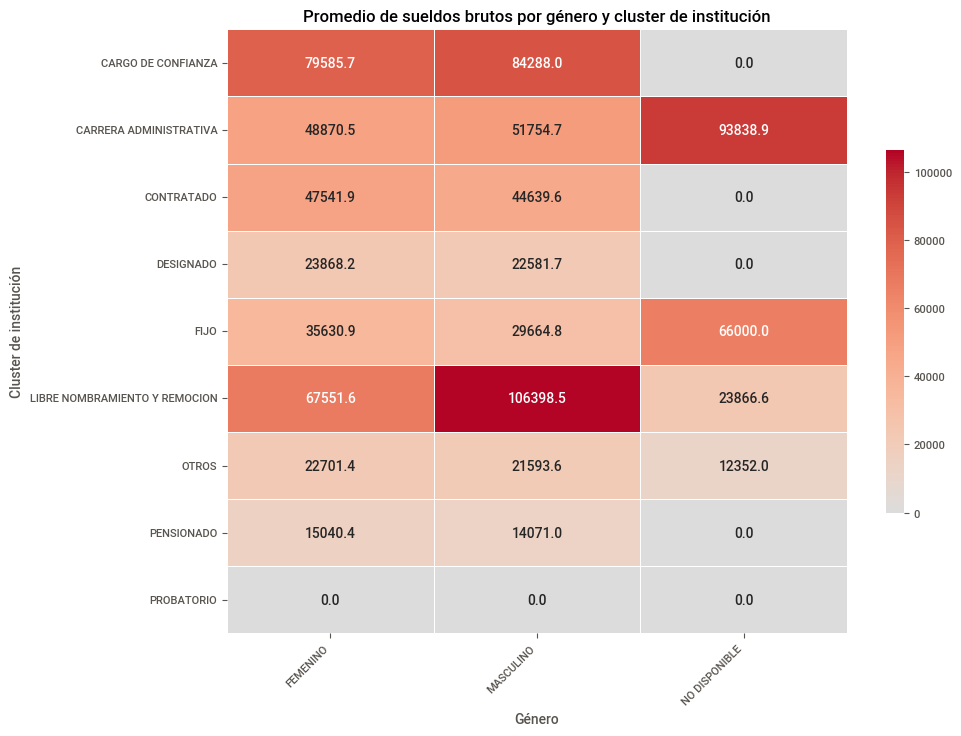

In [28]:
med_1 = "TIPO_EMPLEADO"
top = (
    df[med_1].value_counts().sort_values(ascending=False).head(10).index.values
)

platform_genero_sueldo = (
    df.pivot_table(
        index='TIPO_EMPLEADO', columns="GENERO", values="SUELDO_BRUTO", aggfunc=np.mean
    )
    .fillna(0)
    .applymap(float)
)

plt.figure(figsize=(10, 8))
sns.heatmap(
    platform_genero_sueldo, 
    annot=True, 
    fmt=".1f", 
    linewidths=0.5, 
    cmap='coolwarm',
    center=0,
    cbar_kws={"shrink": 0.6},
)
plt.xlabel('Género')
plt.ylabel('Cluster de institución')
plt.xticks(rotation=45, ha='right')
plt.title('Promedio de sueldos brutos por género y cluster de institución')
plt.show()


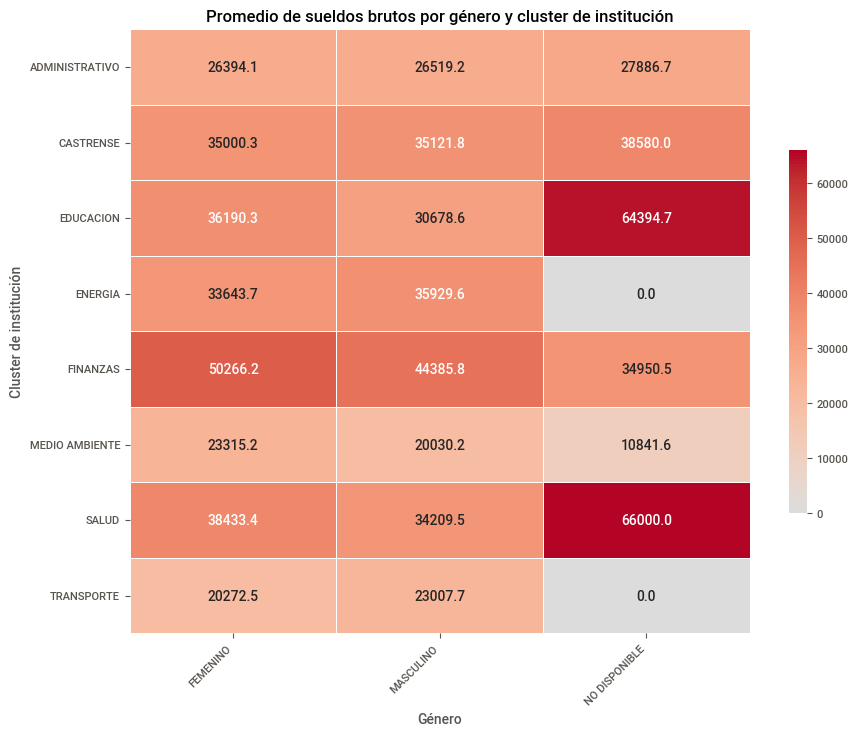

In [29]:
med_1 = "INSTITUCION"
top = (
    df[med_1].value_counts().sort_values(ascending=False).head(10).index.values
)

platform_genero_sueldo = (
    df.pivot_table(
        index='CLUSTER_INSTITUCION', columns="GENERO", values="SUELDO_BRUTO", aggfunc=np.mean
    )
    .fillna(0)
    .applymap(float)
)

plt.figure(figsize=(10, 8))
sns.heatmap(
    platform_genero_sueldo, 
    annot=True, 
    fmt=".1f", 
    linewidths=0.5, 
    cmap='coolwarm',
    center=0,
    cbar_kws={"shrink": 0.6},
)
plt.xlabel('Género')
plt.ylabel('Cluster de institución')
plt.xticks(rotation=45, ha='right')
plt.title('Promedio de sueldos brutos por género y cluster de institución')
plt.show()


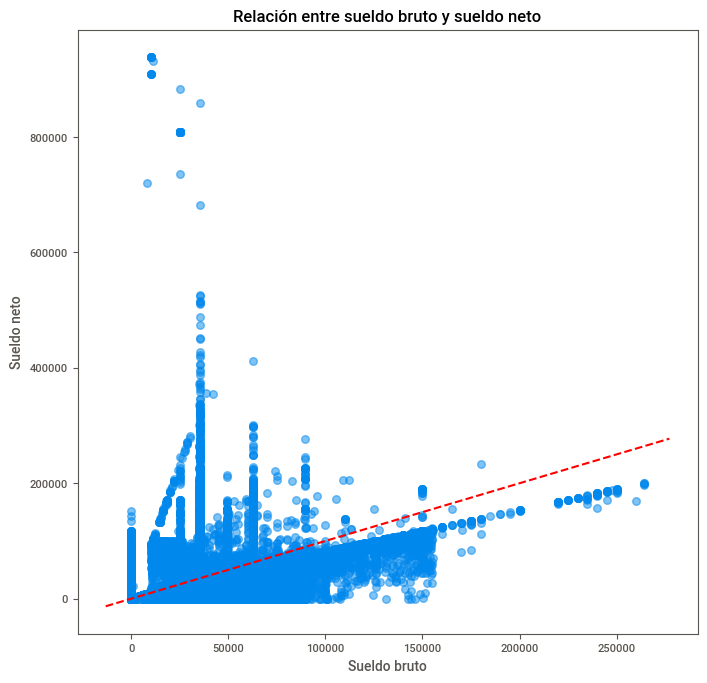

In [30]:
var = 'SUELDO_BRUTO'
data = pd.concat([df['SUELDO_NETO'], df[var]], axis=1)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x=var, y='SUELDO_NETO', data=data, s=30, alpha=0.5)

# Agregar línea de referencia de relación lineal ideal
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, color='red', linestyle='--')

# Configurar etiquetas y título
ax.set_xlabel('Sueldo bruto')
ax.set_ylabel('Sueldo neto')
ax.set_title('Relación entre sueldo bruto y sueldo neto')

plt.show()


# Analisis Demografico

### En el analisis aqui tenemos el exportable Promedio de Sueldos, por Funcion, y por Provincia, aportandonos el valor de cual es el sueldo promedio por variables como:
* GENERO, 
* PROVINCIA, 
* RANGO DE EDAD Y 
* FUNCION

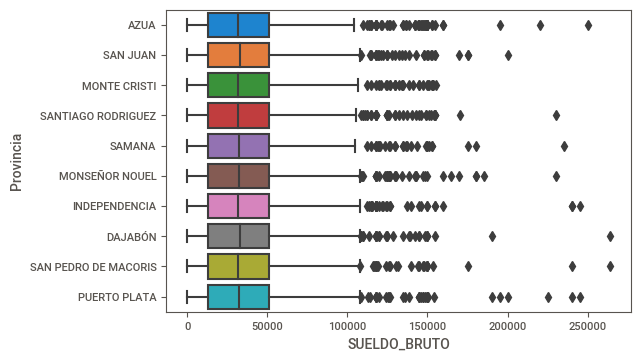

In [31]:
med_1 = "Provincia"
med_2 = "SUELDO_BRUTO"
top = (
    df[med_1].value_counts().sort_values(ascending=False).head(10).index.values
)
sns.boxplot(
    y=med_1,
    x=med_2,
    data=df[df[med_1].isin(top)],
    orient="h",
);

In [32]:
# Agrupar los cargos por provincia y contar la cantidad de empleados en cada cargo
cargos_por_cluster = df.groupby(['INSTITUCION','GENERO', 'FUNCION']).size().reset_index(name='cantidad')

# Obtener los cargos top 5 por cada provincia
top_cargos_por_cluster = cargos_por_cluster.groupby('GENERO').apply(lambda x: x.nlargest(5, 'cantidad'))

top_cargos_por_cluster

INSTITUCION  \
GENERO                                                                   
FEMENINO      9708                             MINISTERIO DE EDUCACION   
              9810                             MINISTERIO DE EDUCACION   
              9807                             MINISTERIO DE EDUCACION   
              15893                   SERVICIO NACIONAL DE SALUD (SNS)   
              9851                             MINISTERIO DE EDUCACION   
MASCULINO     10045                            MINISTERIO DE EDUCACION   
              10050                            MINISTERIO DE EDUCACION   
              10203                            MINISTERIO DE EDUCACION   
              10168                            MINISTERIO DE EDUCACION   
              10166                            MINISTERIO DE EDUCACION   
NO DISPONIBLE 1787   CORPORACION DE ACUEDUCTO Y ALCANTARILLADO DE S...   
              19859       UNIVERSIDAD AUTONOMA DE SANTO DOMINGO (UASD)   
              1251   CONSEJO NACIONAL DE PROMOCION Y APOYO A LA MIC...   
              1252   CONSEJO NACIONAL DE PROMOCION Y APOYO A LA MIC...   
              1253   CONSEJO NACIONAL DE PROMOCION Y APOYO A LA MIC...   

                            GENERO  \
GENERO                               
FEMENINO      9708        FEMENINO   
              9810        FEMENINO   
              9807        FEMENINO   
              15893       FEMENINO   
              9851        FEMENINO   
MASCULINO     10045      MASCULINO   
              10050      MASCULINO   
              10203      MASCULINO   
              10168      MASCULINO   
              10166      MASCULINO   
NO DISPONIBLE 1787   NO DISPONIBLE   
              19859  NO DISPONIBLE   
              1251   NO DISPONIBLE   
              1252   NO DISPONIBLE   
              1253   NO DISPONIBLE   

                                                          FUNCION  cantidad  
GENERO                                                                       
FEMENINO      9708                                    conserje je     22671  
              9810                              maestro basica je     20915  
              9807                                 maestro basica     18468  
              15893                        auxiliar de enfermeria     13555  
              9851                       maestro media general je     12846  
MASCULINO     10045            auxiliar de la policia escolar jee      7548  
              10050                     auxiliar de seguridad jee      6837  
              10203                      maestro media general je      5062  
              10168                             maestro basica je      3887  
              10166                                maestro basica      3436  
NO DISPONIBLE 1787                                      designado       164  
              19859                                      profesor         4  
              1251                                      asistente         1  
              1252               auxiliar de credito puerto plata         1  
              1253   auxiliar de credito san francisco de macoris         1

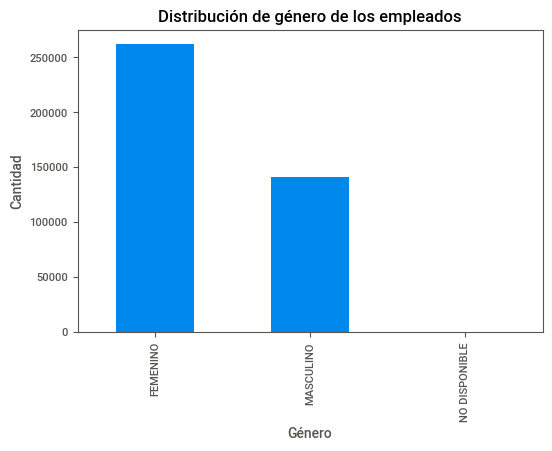

In [33]:
# Calcular la cantidad de empleados de cada género
gender_counts = df['GENERO'].value_counts()

# Crear un gráfico de barras para visualizar la distribución de género
gender_counts.plot(kind='bar')
plt.title('Distribución de género de los empleados')
plt.xlabel('Género')
plt.ylabel('Cantidad')
plt.show()






AttributeError: 'BarContainer' object has no attribute 'set_color'

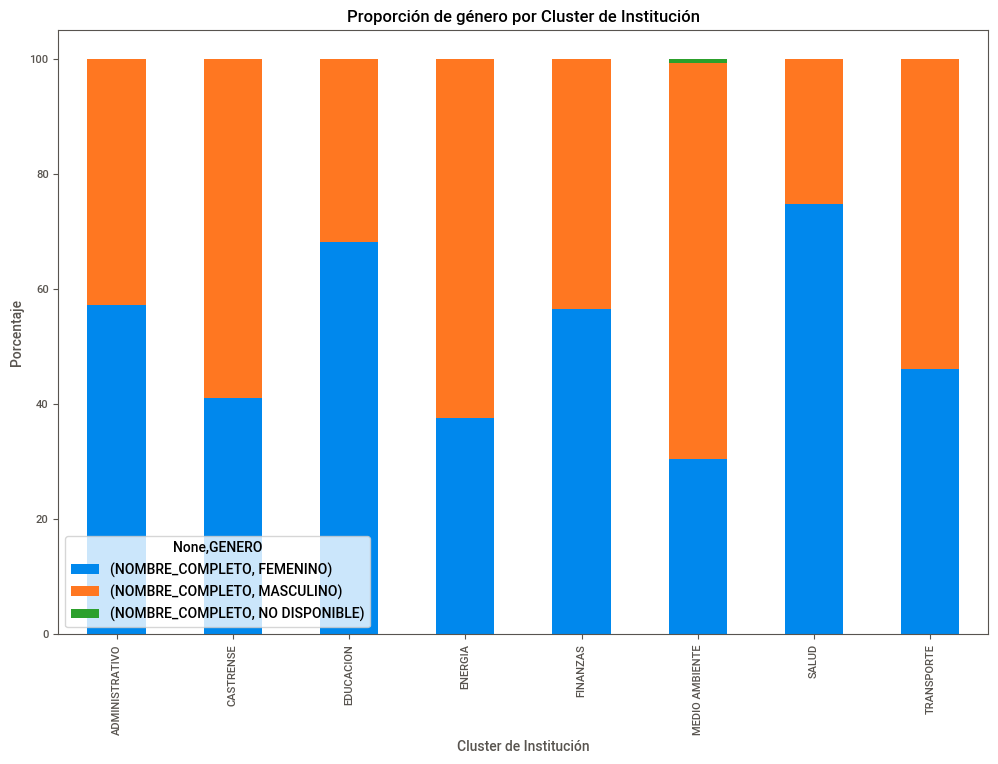

In [34]:
# Contar la cantidad de registros por cluster e género
grouped_data = df.groupby(['CLUSTER_INSTITUCION', 'GENERO']).agg({'NOMBRE_COMPLETO': 'count'}).rename({'NOMBRE_COMPLETO': 'Cantidad'})

# Calcular la proporción de género por cluster
proportions = grouped_data.div(grouped_data.groupby(level=0).sum(), level=0) * 100

# Reorganizar los datos para tener cada género en una columna
proportions = proportions.unstack()

# Graficar la proporción de género por cluster
ax = proportions.plot(kind='bar', stacked=True, figsize=(12,8))
ax.set_xlabel('Cluster de Institución')
ax.set_ylabel('Porcentaje')
ax.set_title('Proporción de género por Cluster de Institución')

# Personalizar los colores de las barras
colors = ['#FFC0CB', '#ADD8E6']
for i, c in enumerate(ax.containers):
    c.set_color(colors[i%len(colors)])

# Agregar leyenda
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='upper right')

plt.show()


In [35]:
# Agrupar por género y profesión, y contar la cantidad de empleados en cada combinación
grouped_data = df.groupby(['GENERO', 'Profesion']).agg({'NOMBRE_COMPLETO': 'count'}).reset_index()

# Ordenar por cantidad de empleados
grouped_data = grouped_data.sort_values(['GENERO', 'NOMBRE_COMPLETO'], ascending=False)

# Seleccionar las 5 principales profesiones para cada género
top_professions_by_gender = grouped_data.groupby('GENERO').head(5)

print(top_professions_by_gender)

            GENERO   Profesion  NOMBRE_COMPLETO
629  NO DISPONIBLE   designado              164
634  NO DISPONIBLE     oficial                6
635  NO DISPONIBLE    profesor                4
628  NO DISPONIBLE    auxiliar                2
626  NO DISPONIBLE    analista                1
337      MASCULINO    auxiliar            25549
497      MASCULINO     maestro            22102
607      MASCULINO     tecnico             5720
624      MASCULINO   vigilante             5659
380      MASCULINO    conserje             5566
185       FEMENINO     maestro            74681
71        FEMENINO    conserje            41403
34        FEMENINO    auxiliar            28802
134       FEMENINO         ent            12475
266       FEMENINO  secretaria            11416


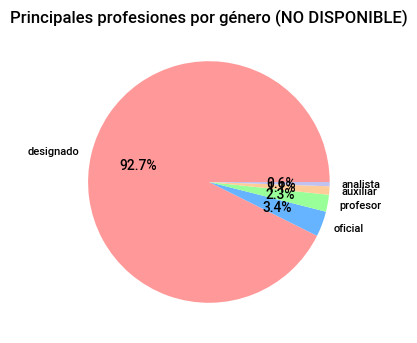

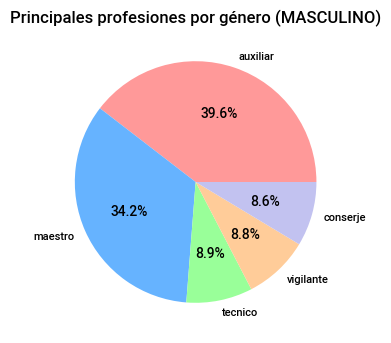

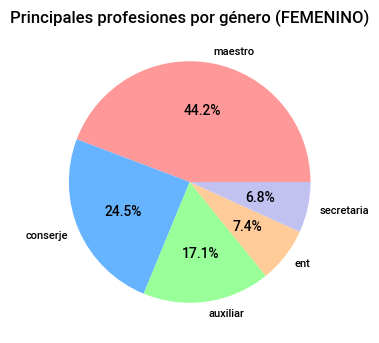

In [36]:
# Crear un gráfico de pastel para cada género
for gender in top_professions_by_gender['GENERO'].unique():
    gender_data = top_professions_by_gender[top_professions_by_gender['GENERO'] == gender]
    plt.pie(gender_data['NOMBRE_COMPLETO'], labels=gender_data['Profesion'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0'])
    plt.title(f'Principales profesiones por género ({gender})')
    plt.show()

In [37]:
# Agrupar los cargos por provincia y contar la cantidad de empleados en cada cargo
gb_df = df.groupby(['Profesion','CLUSTER_INSTITUCION']).size().reset_index(name='cantidad')

top_cargos_por_cluster = gb_df.groupby('CLUSTER_INSTITUCION').apply(lambda x: x.nlargest(5, 'cantidad'))

top_cargos_por_cluster

Profesion CLUSTER_INSTITUCION  cantidad
CLUSTER_INSTITUCION                                               
ADMINISTRATIVO      167     auxiliar      ADMINISTRATIVO      4712
                    88      animador      ADMINISTRATIVO      3912
                    285     conserje      ADMINISTRATIVO      3169
                    1153   vigilante      ADMINISTRATIVO      1633
                    1029  secretaria      ADMINISTRATIVO      1400
CASTRENSE           44        agente           CASTRENSE      2171
                    168     auxiliar           CASTRENSE      1406
                    11       abogado           CASTRENSE       855
                    286     conserje           CASTRENSE       816
                    1030  secretaria           CASTRENSE       815
EDUCACION           713      maestro           EDUCACION     96741
                    287     conserje           EDUCACION     34612
                    169     auxiliar           EDUCACION     23509
                    532          ent           EDUCACION      8118
                    1031  secretaria           EDUCACION      7004
ENERGIA             533          ent             ENERGIA      1082
                    498    encargado             ENERGIA      1002
                    81      analista             ENERGIA       861
                    45        agente             ENERGIA       800
                    1091  supervisor             ENERGIA       571
FINANZAS            164      auditor            FINANZAS       768
                    171     auxiliar            FINANZAS       721
                    82      analista            FINANZAS       629
                    499    encargado            FINANZAS       476
                    289     conserje            FINANZAS       331
MEDIO AMBIENTE      172     auxiliar      MEDIO AMBIENTE      2931
                    849     operador      MEDIO AMBIENTE      2754
                    1113     tecnico      MEDIO AMBIENTE      1884
                    180     ayudante      MEDIO AMBIENTE      1631
                    818       obrero      MEDIO AMBIENTE      1091
SALUD               173     auxiliar               SALUD     20880
                    755       medico               SALUD     14875
                    151     atencion               SALUD      7224
                    291     conserje               SALUD      6532
                    536          ent               SALUD      5710
TRANSPORTE          282    conductor          TRANSPORTE       783
                    216       cajero          TRANSPORTE       669
                    292     conserje          TRANSPORTE       642
                    174     auxiliar          TRANSPORTE       476
                    152     atencion          TRANSPORTE       471

In [38]:
# Agrupar los cargos por provincia y contar la cantidad de empleados en cada cargo
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


gb_df = df.groupby(['Profesion','CLUSTER_INSTITUCION','INSTITUCION']).size().reset_index(name='cantidad')

top_cargos_por_cluster = gb_df.groupby('CLUSTER_INSTITUCION').apply(lambda x: x.nlargest(5, 'cantidad'))


top_cargos_por_cluster


Profesion CLUSTER_INSTITUCION  \
CLUSTER_INSTITUCION                                        
ADMINISTRATIVO      382     animador      ADMINISTRATIVO   
                    680     auxiliar      ADMINISTRATIVO   
                    3649   vigilante      ADMINISTRATIVO   
                    1017    conserje      ADMINISTRATIVO   
                    753     ayudante      ADMINISTRATIVO   
CASTRENSE           196       agente           CASTRENSE   
                    96       abogado           CASTRENSE   
                    703     auxiliar           CASTRENSE   
                    1272     curador           CASTRENSE   
                    3237  secretaria           CASTRENSE   
EDUCACION           2316     maestro           EDUCACION   
                    1043    conserje           EDUCACION   
                    706     auxiliar           EDUCACION   
                    1886         ent           EDUCACION   
                    3240  secretaria           EDUCACION   
ENERGIA             1891         ent             ENERGIA   
                    1794   encargado             ENERGIA   
                    198       agente             ENERGIA   
                    197       agente             ENERGIA   
                    1795   encargado             ENERGIA   
FINANZAS            661      auditor            FINANZAS   
                    662      auditor            FINANZAS   
                    1799   encargado            FINANZAS   
                    1176     control            FINANZAS   
                    716     auxiliar            FINANZAS   
MEDIO AMBIENTE      3576     tecnico      MEDIO AMBIENTE   
                    724     auxiliar      MEDIO AMBIENTE   
                    2724    operador      MEDIO AMBIENTE   
                    2723    operador      MEDIO AMBIENTE   
                    780     ayudante      MEDIO AMBIENTE   
SALUD               733     auxiliar               SALUD   
                    2453      medico               SALUD   
                    630     atencion               SALUD   
                    1068    conserje               SALUD   
                    1911         ent               SALUD   
TRANSPORTE          848       cajero          TRANSPORTE   
                    1002   conductor          TRANSPORTE   
                    631     atencion          TRANSPORTE   
                    1071    conserje          TRANSPORTE   
                    2201   inspector          TRANSPORTE   

                                                                INSTITUCION  \
CLUSTER_INSTITUCION                                                           
ADMINISTRATIVO      382   INSTITUTO NACIONAL DE ATENCION INTEGRAL A LA P...   
                    680   INSTITUTO NACIONAL DE ATENCION INTEGRAL A LA P...   
                    3649  INSTITUTO NACIONAL DE ATENCION INTEGRAL A LA P...   
                    1017  INSTITUTO NACIONAL DE ATENCION INTEGRAL A LA P...   
                    753                  MINISTERIO DE INDUSTRIA Y COMERCIO   
CASTRENSE           196                PROCURADURIA GENERAL DE LA REPUBLICA   
                    96                 PROCURADURIA GENERAL DE LA REPUBLICA   
                    703                PROCURADURIA GENERAL DE LA REPUBLICA   
                    1272               PROCURADURIA GENERAL DE LA REPUBLICA   
                    3237               PROCURADURIA GENERAL DE LA REPUBLICA   
EDUCACION           2316                            MINISTERIO DE EDUCACION   
                    1043                            MINISTERIO DE EDUCACION   
                    706                             MINISTERIO DE EDUCACION   
                    1886                            MINISTERIO DE EDUCACION   
                    3240                            MINISTERIO DE EDUCACION   
ENERGIA             1891                                           EDENORTE   
                    1794                                           EDENORTE   
     

In [39]:
pd.set_option('display.max_rows', 25) # mostrar todas las filas
pd.set_option('display.max_columns', None) # mostrar todas las columnas

# Agrupar los cargos por provincia y contar la cantidad de empleados en cada cargo
cargos_por_cluster = df.groupby(['Profesion','FUNCION']).size().reset_index(name='cantidad')

# Obtener los cargos top 5 por cada provincia
top_cargos_por_cluster = cargos_por_cluster.groupby('Profesion').apply(lambda x: x.nlargest(5, 'cantidad'))

top_cargos_por_cluster = top_cargos_por_cluster.sort_values(by='cantidad', ascending=False)
top_cargos_por_cluster.head(25).sort_values(by='cantidad', ascending=False )

Profesion                             FUNCION  cantidad
Profesion                                                                 
conserje   3967     conserje                         conserje je     25629
maestro    8676      maestro                   maestro basica je     24802
           8673      maestro                      maestro basica     21904
conserje   3906     conserje                            conserje     20922
maestro    8722      maestro            maestro media general je     17908
auxiliar   3098     auxiliar              auxiliar de enfermeria     14593
maestro    8713      maestro                  maestro inicial je      8697
auxiliar   3155     auxiliar  auxiliar de la policia escolar jee      8539
medico     8897       medico                      medico general      7446
auxiliar   3227     auxiliar           auxiliar de seguridad jee      7428
atencion   2660     atencion      enfermero (a) atencion directa      6017
vigilante  10917   vigilante                           vigilante      5647
secretaria 9981   secretaria                       secretaria je      5129
           9940   secretaria                          secretaria      4397
ent        7712          ent                orientador basica je      4369
cocinero   3862     cocinero                         cocinero je      4137
chofer     3789       chofer                              chofer      3891
auxiliar   2842     auxiliar             auxiliar administrativo      3846
animador   2144     animador                animador comunitario      3671
auxiliar   2814     auxiliar                            auxiliar      3530
maestro    8728      maestro      maestro tecnico profesional jc      3457
monitor    9158      monitor                             monitor      3021
digitador  5463    digitador                        digitador je      2776
medico     8939       medico               medico pasante de ley      2740
mayor      8752        mayor                        mayordomo je      2733

In [40]:
# Agrupar los cargos por provincia y contar la cantidad de empleados en cada cargo
cargos_por_cluster = df.groupby(['GENERO','Profesion']).size().reset_index(name='cantidad')

# Obtener los cargos top 5 por cada provincia
top_cargos_por_cluster = cargos_por_cluster.groupby('Profesion').apply(lambda x: x.nlargest(5, 'cantidad'))

top_cargos_por_cluster = top_cargos_por_cluster.sort_values(by='cantidad', ascending=False)
top_cargos_por_cluster.head(25).sort_values(by='cantidad', ascending=False )

GENERO    Profesion  cantidad
Profesion                                        
maestro     185   FEMENINO      maestro     74681
conserje    71    FEMENINO     conserje     41403
auxiliar    34    FEMENINO     auxiliar     28802
            337  MASCULINO     auxiliar     25549
maestro     497  MASCULINO      maestro     22102
ent         134   FEMENINO          ent     12475
secretaria  266   FEMENINO   secretaria     11416
medico      194   FEMENINO       medico     10943
atencion    31    FEMENINO     atencion      7488
Desconocido 2     FEMENINO  Desconocido      6061
tecnico     607  MASCULINO      tecnico      5720
vigilante   624  MASCULINO    vigilante      5659
conserje    380  MASCULINO     conserje      5566
chofer      367  MASCULINO       chofer      5429
ayudante    338  MASCULINO     ayudante      4660
cocinero    62    FEMENINO     cocinero      4323
medico      510  MASCULINO       medico      4066
tecnico     284   FEMENINO      tecnico      3866
director    100   FEMENINO     director      3863
analista    17    FEMENINO     analista      3658
animador    19    FEMENINO     animador      3635
ent         438  MASCULINO          ent      3559
supervisor  601  MASCULINO   supervisor      3277
operador    540  MASCULINO     operador      3131
promotor    245   FEMENINO     promotor      3027

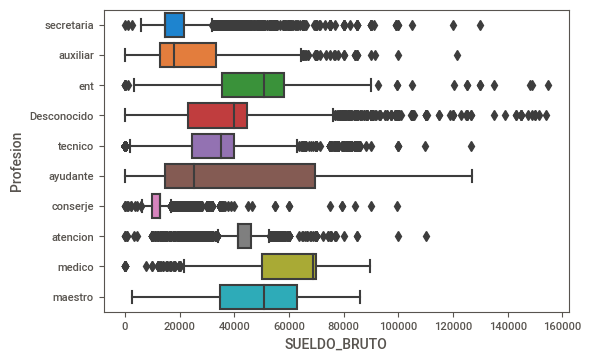

In [41]:
med_1 = "Profesion"
med_2 = "SUELDO_BRUTO"
top = (
    df[med_1].value_counts().sort_values(ascending=False).head(10).index.values
)
sns.boxplot(
    y=med_1,
    x=med_2,
    data=df[df[med_1].isin(top)],
    orient="h",
);

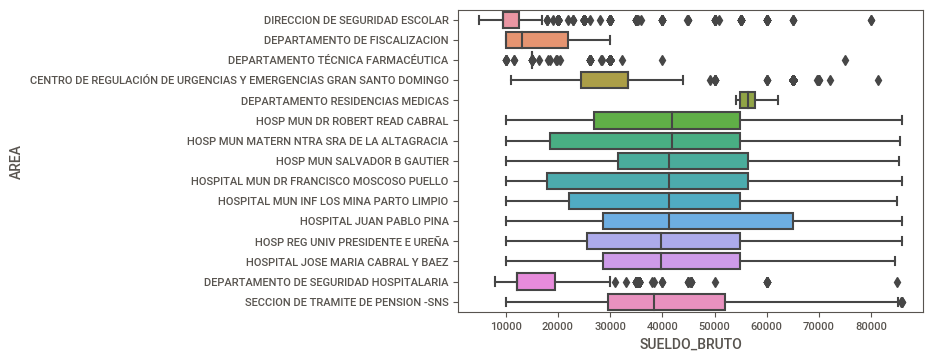

In [42]:
med_1 = "AREA"
med_2 = "SUELDO_BRUTO"
top = (
    df[med_1].value_counts().sort_values(ascending=False).head(15).index.values
)
sns.boxplot(
    y=med_1,
    x=med_2,
    data=df[df[med_1].isin(top)],
    orient="h",
);

In [43]:
gb_df = df.groupby(['Profesion']).SUELDO_BRUTO.agg([len, np.min,\
                                                               np.max,np.mean,np.std]).rename(columns={'len': 'Cant. Empleados',\
                                                                                                'amin': 'Sueldo Minimo',\
                                                                                               'amax': 'Sueldo Maximo',\
                                                                                               'mean': 'Sueldo Promedio',\
                                                                                                'std': 'Desviacion Estandar'})

gb_df['Sueldo Promedio'] = gb_df['Sueldo Promedio'].round()
gb_df['Sueldo Promedio'] = gb_df['Sueldo Promedio'].apply('{:,}'.format)



gb_df['Sueldo Maximo'] = gb_df['Sueldo Maximo'].round()
gb_df['Sueldo Maximo'] = gb_df['Sueldo Maximo'].apply('{:,}'.format)

gb_df['Sueldo Minimo'] = gb_df['Sueldo Minimo'].round()
gb_df['Sueldo Minimo'] = gb_df['Sueldo Minimo'].apply('{:,}'.format)

gb_df['Desviacion Estandar'] = gb_df['Desviacion Estandar'].round()
gb_df['Desviacion Estandar'] = gb_df['Desviacion Estandar'].apply('{:,}'.format)



gb_df.head(25).sort_values(by='Cant. Empleados', ascending=False )




,Cant. Empleados,Sueldo Minimo,Sueldo Maximo,Sueldo Promedio,Desviacion Estandar
Profesion,,,,,
Desconocido,7700,0.0,"154,084.0","35,541.0","18,554.0"
analista,5926,0.0,"150,000.0","48,899.0","18,946.0"
agente,3898,0.0,"70,000.0","22,948.0","7,197.0"
abogado,1825,0.0,"154,720.0","43,022.0","18,607.0"
ama,1475,0.0,"150,000.0","32,120.0","24,372.0"
administrador,300,0.0,"145,000.0","47,735.0","22,500.0"
actor,214,"10,000.0","65,000.0","12,677.0","6,457.0"
albañil,89,"10,000.0","49,913.0","20,690.0","8,480.0"
agrimensor,82,0.0,"83,105.0","43,808.0","14,315.0"


In [44]:
# Calcular el sueldo promedio por profesión
avg_salaries_by_profession = df.groupby('Profesion')['SUELDO_BRUTO'].mean().sort_values(ascending=False)

# Calcular la cantidad de empleados por profesión
employee_counts_by_profession = df['Profesion'].value_counts()

# Imprimir los resultados
print("Sueldo promedio por profesión:")
print(avg_salaries_by_profession)

print("Cantidad de empleados por profesión:")
employee_counts_by_profession

Sueldo promedio por profesión:
Profesion
gobernador       110405.261429
minísterio        95000.000000
fziscalizador     90000.000000
dfiscalizador     90000.000000
cartógrafo        84240.000000
                     ...      
raso               6745.454545
vice               5372.026798
agregado           3182.352941
primer             2988.085781
veterinario           0.000000
Name: SUELDO_BRUTO, Length: 388, dtype: float64
Cantidad de empleados por profesión:


maestro          96785
auxiliar         55162
conserje         47468
ent              16075
medico           15230
                 ...  
tapicero             1
costurero            1
ductero              1
encestmtaerop        1
stecretaria          1
Name: Profesion, Length: 388, dtype: int64

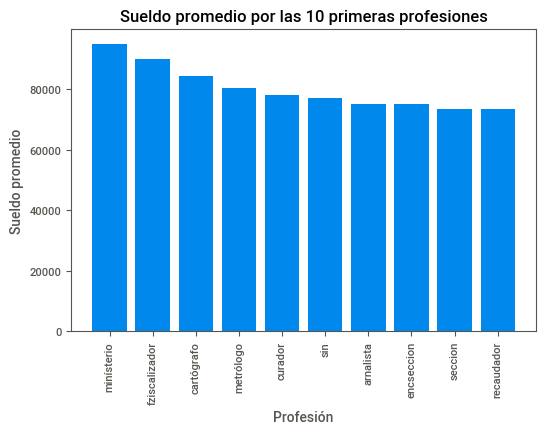

In [45]:
# Calcular el sueldo promedio por profesión
df_mas = df[df['GENERO']=='MASCULINO']
avg_salaries_by_profession = df_mas.groupby('Profesion')['SUELDO_BRUTO'].mean().sort_values(ascending=False)

# Seleccionar las 10 primeras profesiones
top_10_professions = avg_salaries_by_profession.head(10)

# Crear un gráfico de barras para visualizar los sueldos promedios por las 10 primeras profesiones
plt.bar(top_10_professions.index, top_10_professions.values)
plt.xticks(rotation=90)
plt.title('Sueldo promedio por las 10 primeras profesiones')
plt.xlabel('Profesión')
plt.ylabel('Sueldo promedio')
plt.show()




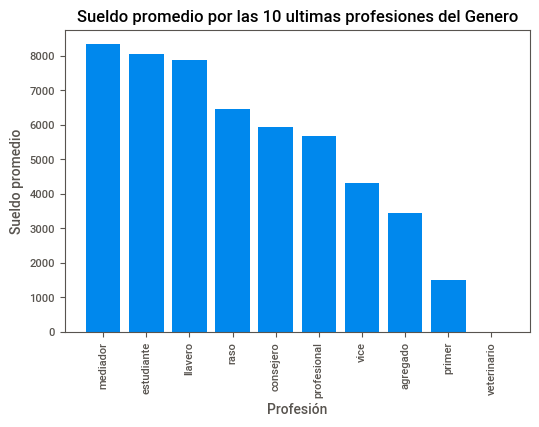

In [46]:
# Calcular el sueldo promedio por profesión
df_mas = df[df['GENERO']=='MASCULINO']
avg_salaries_by_profession = df_mas.groupby('Profesion')['SUELDO_BRUTO'].mean().sort_values(ascending=False)

# Seleccionar las 10 primeras profesiones
top_10_professions = avg_salaries_by_profession.tail(10)

# Crear un gráfico de barras para visualizar los sueldos promedios por las 10 primeras profesiones
plt.bar(top_10_professions.index, top_10_professions.values)
plt.xticks(rotation=90)
plt.title('Sueldo promedio por las 10 ultimas profesiones del Genero')
plt.xlabel('Profesión')
plt.ylabel('Sueldo promedio')
plt.show()


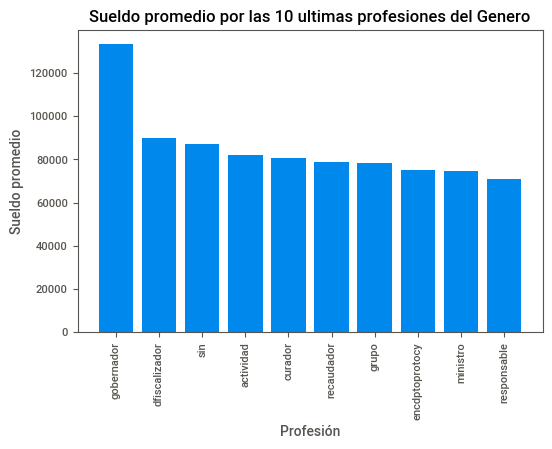

In [47]:
# Calcular el sueldo promedio por profesión
df_fem = df[df['GENERO']=='FEMENINO']
avg_salaries_by_profession = df_fem.groupby('Profesion')['SUELDO_BRUTO'].mean().sort_values(ascending=False)

# Seleccionar las 10 primeras profesiones
top_10_professions = avg_salaries_by_profession.head(10)

# Crear un gráfico de barras para visualizar los sueldos promedios por las 10 primeras profesiones
plt.bar(top_10_professions.index, top_10_professions.values)
plt.xticks(rotation=90)
plt.title('Sueldo promedio por las 10 ultimas profesiones del Genero')
plt.xlabel('Profesión')
plt.ylabel('Sueldo promedio')
plt.show()

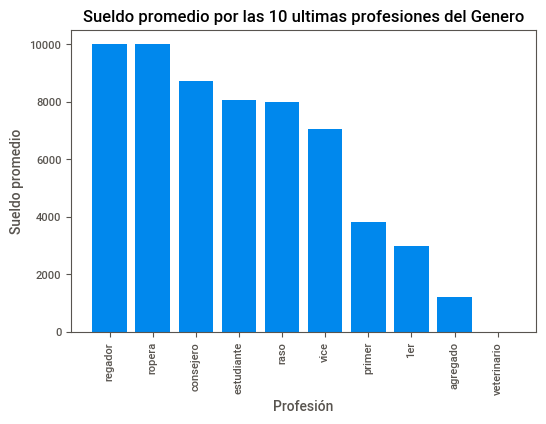

In [48]:
# Calcular el sueldo promedio por profesión
df_fem = df[df['GENERO']=='FEMENINO']
avg_salaries_by_profession = df_fem.groupby('Profesion')['SUELDO_BRUTO'].mean().sort_values(ascending=False)

# Seleccionar las 10 primeras profesiones
top_10_professions = avg_salaries_by_profession.tail(10)

# Crear un gráfico de barras para visualizar los sueldos promedios por las 10 primeras profesiones
plt.bar(top_10_professions.index, top_10_professions.values)
plt.xticks(rotation=90)
plt.title('Sueldo promedio por las 10 ultimas profesiones del Genero')
plt.xlabel('Profesión')
plt.ylabel('Sueldo promedio')
plt.show()

In [49]:
# Eliminar filas con valores NaN en la columna "Área"
data = df.dropna(subset=['AREA'])

# Agrupar por área y profesión, y calcular cantidad de empleados y sueldo bruto promedio
grouped_data = df.groupby(['AREA', 'Profesion']).agg({'NOMBRE_COMPLETO': 'count', 'SUELDO_BRUTO': 'mean'}).reset_index()

# Ordenar por cantidad de empleados y sueldo bruto promedio
grouped_data = grouped_data.sort_values(['AREA', 'NOMBRE_COMPLETO', 'SUELDO_BRUTO'], ascending=False)

# Seleccionar las principales profesiones para cada área
top_professions_by_area = grouped_data.groupby('AREA').head(3)

top_professions_by_area.head(25).sort_values(by='NOMBRE_COMPLETO', ascending=False )

,AREA,Profesion,NOMBRE_COMPLETO,SUELDO_BRUTO
96691,ZONA FRANCA DE SAN CRISTOBAL,vigilante,8,10750.000000
96674,ZONA FRANCA DE MOCA,vigilante,7,12285.714286
96676,ZONA FRANCA DE PERAVIA,ayudante,6,13915.000000
96668,ZONA FRANCA DE LOS ALCARRIZOS,vigilante,5,10000.000000
96696,ZONA FRANCA DE SAN FCO DE MACORIS,vigilante,4,11500.000000
96684,ZONA FRANCA DE QUISQUEYA,vigilante,4,11500.000000
96689,ZONA FRANCA DE SAN CRISTOBAL,obrero,4,11500.000000
96686,ZONA FRANCA DE SALCEDO,vigilante,2,12000.000000
96671,ZONA FRANCA DE MOCA,conserje,2,10000.000000
96669,ZONA FRANCA DE MOCA,auxiliar,2,22000.000000
